In [1]:
import os
os.environ['DRJIT_LIBLLVM_PATH'] = 'C:\\Program Files\\LLVM\\bin\\LLVM-C.dll'
#print(os.environ['DRJIT_LIBLLVM_PATH'])
import sionna
import mitsuba as mi
import drjit as dr
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, HTML
# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, Antenna, AntennaArray
# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from Movement import *
from Visualization import *
from helper import *
from Channel import *
from DFT_Codebook import *
import math

In [2]:
#tf.random.set_seed(10)
itu_metal_scattering_coefficient = 0.707 # To define the  scattering coefficient based on Sionna R = sqrt(1-S**2)
itu_concrete_scattering_coefficient = 0.707 # To define the  scattering coefficient based on Sionna R = sqrt(1-S**2)

c = 299792458.0 # m/s

N_r = 12
L_r = 8

N_t = 12
L_t = 8


initial_position_cartesian = cylindrical_to_cartesian([2.5, math.radians(-7.20724334), 0])
initial_position_cartesian 

array([ 2.48024712, -0.31364664,  0.        ])

In [3]:
scene = load_scene('C:\\Users\\dehghani\\Documents\\test_scene\\scene.xml')

In [4]:
#scene.tx_array = AntennaArray(antenna=Antenna("iso", "V"),
                     #positions=tf.Variable([[0,0,0], [0, 1, 1], [0, 1, 3]]))
#scene.rx_array = AntennaArray(antenna=Antenna("iso", "V"),
                     #positions=tf.Variable([[0,0,0], [0, 1, 1]]))



# Create transmitter
#tx = Transmitter(name = "tx",
                 #position = tx_position)

#tx.look_at([1.5,1,0.94]) 

# Add transmitter instance to scene
#scene.add(tx)

# Create a receiver
#rx = Receiver(name = "rx",
              #position = rx_position)

#rx.look_at([1.5,1,0.94]) 

# Add receiver instance to scene
#scene.add(rx)

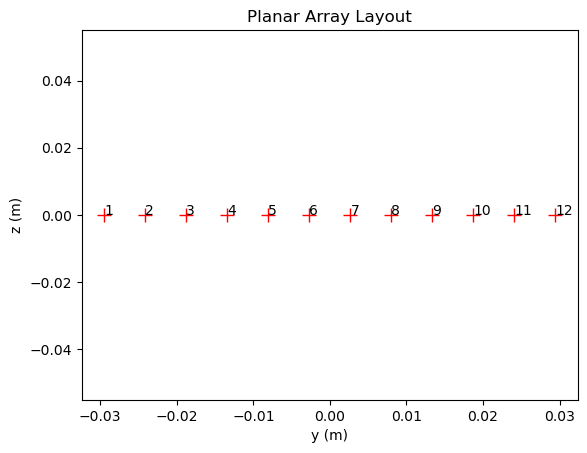

In [5]:
scene.frequency = 28e9

scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

scene.tx_array = PlanarArray(num_rows=1,
                          num_cols = N_t,
                          vertical_spacing = 0.5,
                          horizontal_spacing= 0.5,
                          pattern="tr38901",
                          polarization="H")


scene.rx_array = PlanarArray(num_rows=1,
                          num_cols = N_r,
                          vertical_spacing= 0.5,
                          horizontal_spacing= 0.5,
                          pattern="tr38901",
                          polarization="H")

# tx and rx in cartesian coordinate
tx_position = [0,(N_t * scene.wavelength)/4,.94]
rx_position = [0,-(N_r * scene.wavelength)/4,.94]


scene.rx_array.show()

# Create transmitter
tx = Transmitter(name = "tx",
                 position = tx_position)


# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name = "rx",
              position = rx_position)

# Add receiver instance to scene
scene.add(rx)

In [6]:
for rm in scene.radio_materials.values():
    if rm.name=='itu_metal' :
        print(f'Before: rm.name: {rm.name} and   rm.scattering_coefficient = { rm.scattering_coefficient}')
        rm.scattering_coefficient= itu_metal_scattering_coefficient
        print(f'After: rm.name: {rm.name} and   rm.scattering_coefficient = { rm.scattering_coefficient}')
        
    if rm.name=='itu_concrete' :
        rm.scattering_coefficient = itu_concrete_scattering_coefficient

   #     rm.scattering_pattern = BackscatteringPattern(alpha_r=20, alpha_i=30, lambda_=0.5)

Before: rm.name: itu_metal and   rm.scattering_coefficient = 0.0
After: rm.name: itu_metal and   rm.scattering_coefficient = 0.7070000171661377


In [7]:
params = mi.traverse(scene._scene)
positions = dr.unravel(mi.Point3f, params['mesh-Robot.vertex_positions'])

positions.x += initial_position_cartesian[0]
positions.y += initial_position_cartesian[1]
positions.z += initial_position_cartesian[2]

params['mesh-Robot.vertex_positions'] = dr.ravel(positions)
params.update()

[(PLYMesh[
    name = "Robot.ply",
    bbox = BoundingBox3f[
      min = [1.93025, -0.563647, 0.84],
      max = [3.03025, -0.0636466, 1.04]
    ],
    vertex_count = 14,
    vertices = [280 B of vertex data],
    face_count = 12,
    faces = [144 B of face data],
    face_normals = 1
  ],
  {'vertex_positions'}),
 (Scene[
    children = [
      PathIntegrator[
        max_depth = 12,
        rr_depth = 5
      ],
      TwoSided[
        brdf[0] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.686317, 0.738673]]
          ]
        ],
        brdf[1] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.686317, 0.738673]]
          ]
        ]
      ],
      TwoSided[
        brdf[0] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.043496, 0.011812]]
          ]
        ],
        brdf[1] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
 

In [8]:
scene._solver_paths = Solver(scene)
paths = scene.compute_paths(method='fibonacci', max_depth=1, num_samples=1e7, reflection=False, scattering=True,
                                    diffraction=False, los=True)
paths.normalize_delays = False
h_nlos , tau_nlos = paths.cir(los=False, reflection=False, diffraction=False, scattering=True)

In [9]:
scene.preview(paths, show_devices=True, show_paths=True) 

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [10]:
# h_nlos = [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, max_num_paths, num_time_steps], tf.complex
h_nlos

<tf.Tensor: shape=(1, 1, 12, 1, 12, 1992, 1), dtype=complex64, numpy=
array([[[[[[[ 7.35447259e-09-6.80103369e-08j],
            [ 3.80678138e-08+5.26451061e-09j],
            [ 9.85786830e-09+3.01890495e-08j],
            ...,
            [ 3.66147397e-05-4.14052920e-06j],
            [-1.52041830e-05-3.06046204e-05j],
            [-3.30562252e-05+1.43406978e-05j]],

           [[ 8.80312179e-09-6.78380374e-08j],
            [ 3.83410139e-08+2.61533750e-09j],
            [ 1.26277708e-08+2.91392439e-08j],
            ...,
            [ 2.96208545e-05-2.19177527e-05j],
            [-3.18359416e-05-1.24210665e-05j],
            [-1.95055109e-05+3.02969438e-05j]],

           [[ 1.02477795e-08-6.76348861e-08j],
            [ 3.84300876e-08-4.63955541e-11j],
            [ 1.52878155e-08+2.78359273e-08j],
            ...,
            [ 1.46654829e-05-3.38039426e-05j],
            [-3.19131104e-05+1.22214333e-05j],
            [ 6.28677299e-07+3.60274134e-05j]],

           ...,

          

In [11]:
# Azimuth angle of arrival and departure
azimuth_departure_list = []
azimuth_arrival_list = []

for path_idx in range(h_nlos.shape[-2]):
    azimuth_departure_list.append(np.rad2deg(paths.phi_t[0,0,0,path_idx]))
    azimuth_arrival_list.append(np.rad2deg(paths.phi_r[0,0,0,path_idx]))

# Transmitting Codebook


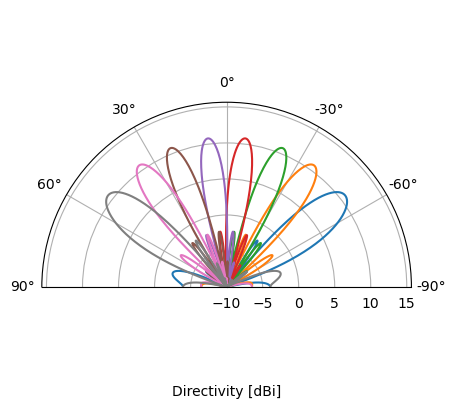

array([-50.45070341, -36.03621672, -21.62173003,  -7.20724334,
         7.20724334,  21.62173003,  36.03621672,  50.45070341])

In [12]:
transmitting_codebook = Codebook(L_max = L_t , N1 = N_t, az_min = -60, az_max = 60)
transmitting_codebook_vectors, beam_degs = transmitting_codebook.beamforming_vectors()
transmitting_codebook.plot_beamforming_polar(transmitting_codebook_vectors)
beam_degs

In [13]:
# Reverse the order of arrays
reversed_vectors = reversed(transmitting_codebook_vectors)
transmitting_codebook_vectors = list(reversed_vectors)
#transmitting_codebook_vectors

# Receiving Codebook

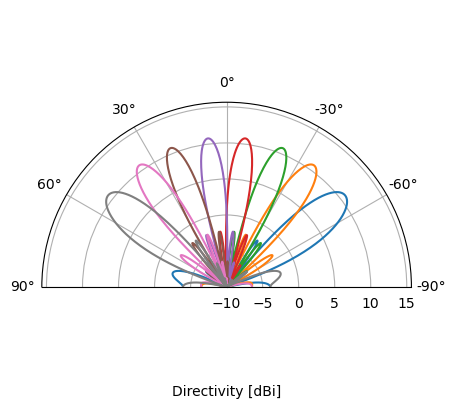

array([-50.45070341, -36.03621672, -21.62173003,  -7.20724334,
         7.20724334,  21.62173003,  36.03621672,  50.45070341])

In [14]:
receiving_codebook = Codebook(L_max = L_r , N1 = N_r, az_min = -60, az_max = 60)
receiving_codebook_vectors, beam_degs = receiving_codebook.beamforming_vectors()
receiving_codebook.plot_beamforming_polar(receiving_codebook_vectors)
beam_degs

In [15]:
#receiving_codebook_vectors

In [16]:
# Removing the redundant dimesions from h_nlos --> (batch size (rays), receiving antennas, transmitting antennas)
h_nlos_reshaped = tf.squeeze(h_nlos, [0,1,3,6])
h_nlos_reshaped = tf.transpose(h_nlos_reshaped, perm=[2, 0, 1]) 

In [17]:
# Generating a matrix out of transmitting_codebook_vectors --> # (batch size, N_t, L_t)
transmitting_codebook_matrix = np.stack(transmitting_codebook_vectors, axis = -1)  # (N_t, L_t)
# Add the dummy batch dimension
transmitting_codebook_matrix = np.expand_dims(transmitting_codebook_matrix, axis=0).astype(np.complex64)  # (batch size, N_t, L_t)
#transmitting_codebook_matrix

In [18]:
# Beam forming at the Transmitter by applying the weights 
# (batch size, N_r, N_t) * (batch size, N_t, L_t) = (batch size, N_r, L_t))

beam_formed_transmitting_signal = tf.matmul(h_nlos_reshaped, transmitting_codebook_matrix) 
#beam_formed_transmitting_signal # (batch size, N_r, L_t)

In [19]:
# Generating a matrix out of receiving_codebook_vectors --> # (batch size, N_r, L_r)
receiving_codebook_matrix = np.stack(receiving_codebook_vectors, axis = -1)  # (N_r, L_r)
# Add the dummy batch dimension
receiving_codebook_matrix = np.expand_dims(receiving_codebook_matrix, axis=0).astype(np.complex64)  # (batch size, N_r, L_r)

In [20]:
# Beam forming at the receiver by applying the weights 
# (batch size, N_r, L_r).T.conj() * (batch size (rays), N_r, L_t) = (batch size, L_r, N_t))

beam_formed_receiving_signal = tf.matmul(receiving_codebook_matrix, beam_formed_transmitting_signal, adjoint_a=True) 
#beam_formed_receiving_signal # (batch size, L_r, L_t)

In [21]:
# tau_nlos = [batch_size, num_rx, num_tx, max_num_paths]
tau_nlos = tf.squeeze(tau_nlos)
tau_nlos

<tf.Tensor: shape=(1992,), dtype=float32, numpy=
array([6.2812622e-09, 6.2764731e-09, 6.2748704e-09, ..., 1.3033435e-08,
       1.3209370e-08, 1.3085298e-08], dtype=float32)>

In [22]:
# Reshape the tensor to a 2D array
reshaped_array = tf.reshape(beam_formed_receiving_signal, (tau_nlos.shape[0], L_r * L_t))
columns = [f'{i},{j}' for i in range(1, L_r + 1) for j in range(1, L_t + 1)]
df_nlos = pd.DataFrame(reshaped_array.numpy(), columns=columns)
df_nlos = df_nlos.set_index(pd.Index(tau_nlos))
#df_nlos

In [23]:
channel_magnitude_df_nlos = abs_complex_columns(df_nlos)
channel_magnitude_df_nlos_db = 20 * np.log10(channel_magnitude_df_nlos)

C:\Users\dehghani\AppData\Local\Temp\ipykernel_14284\324403783.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(12, 4))


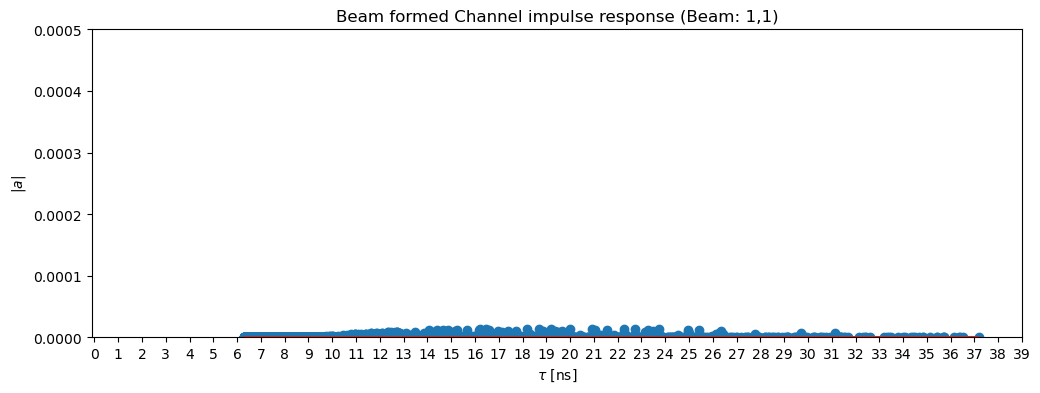

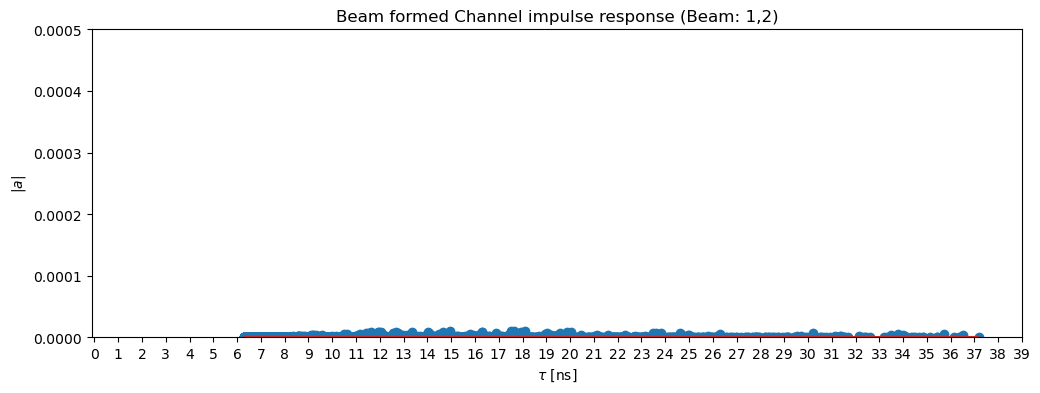

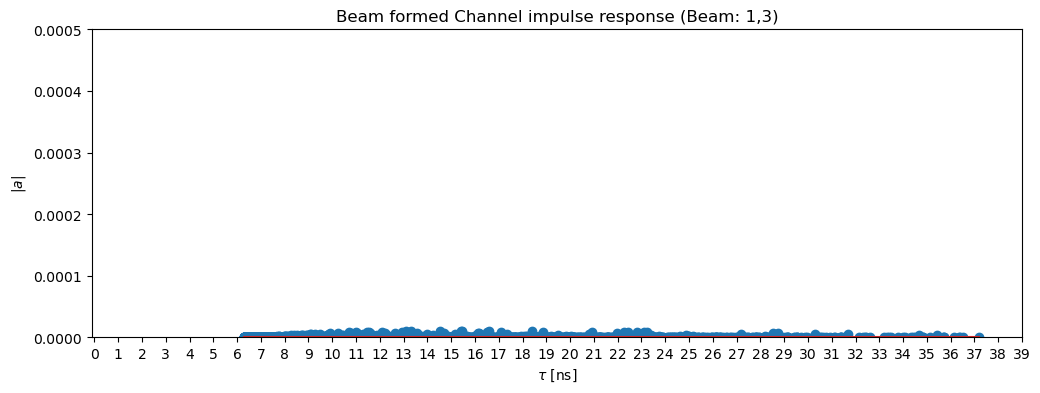

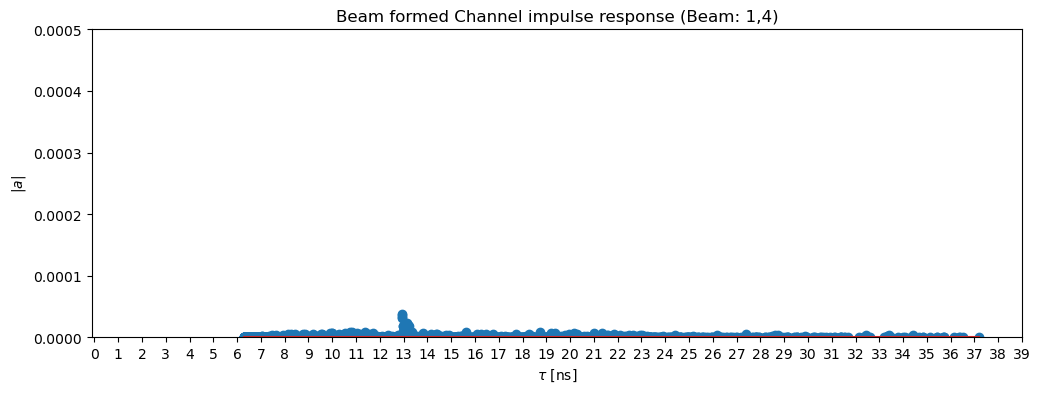

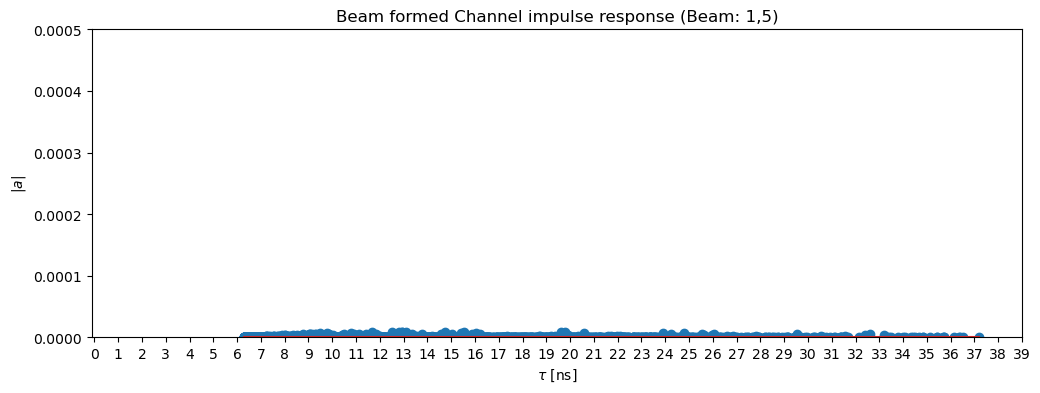

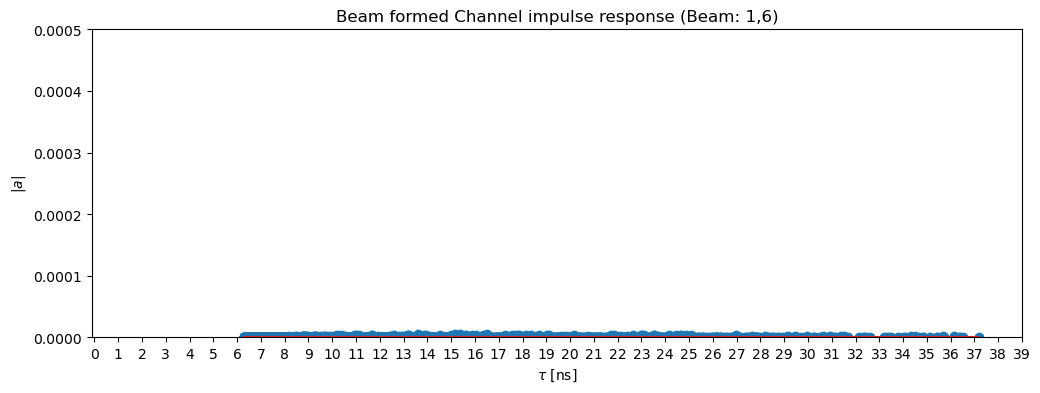

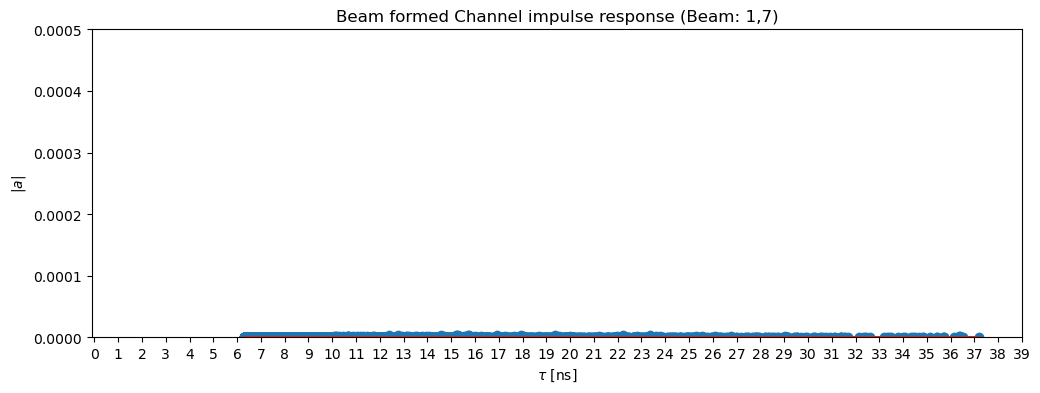

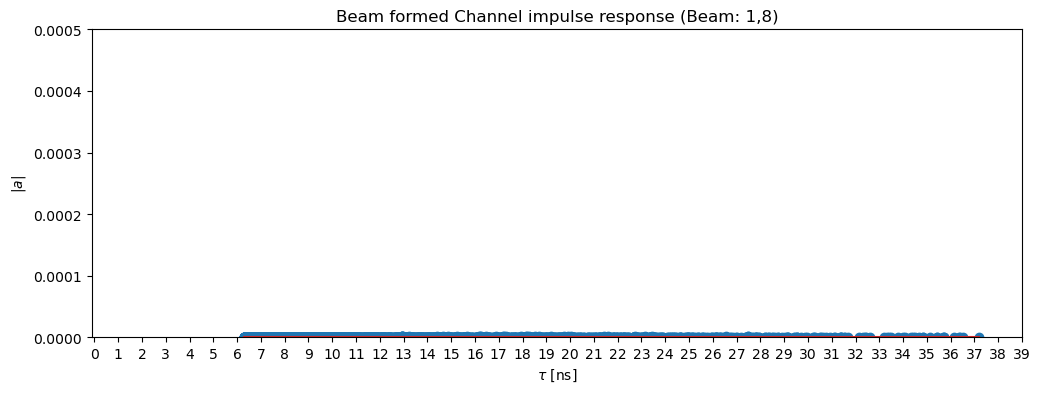

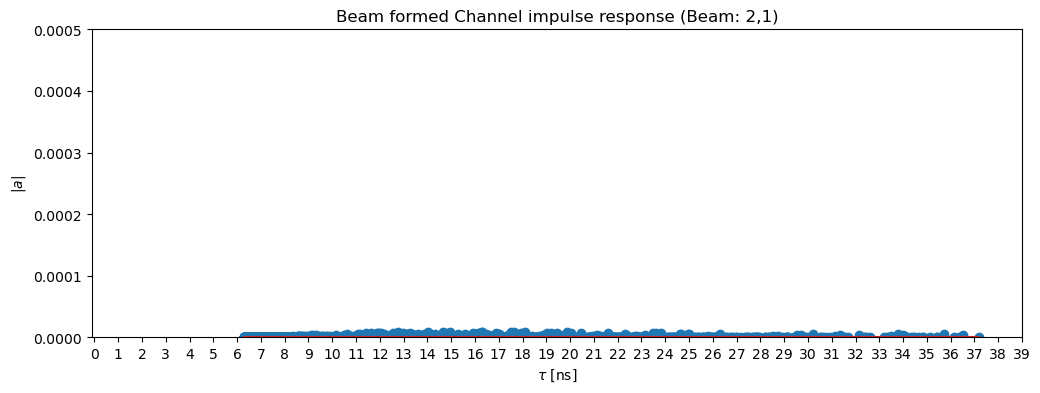

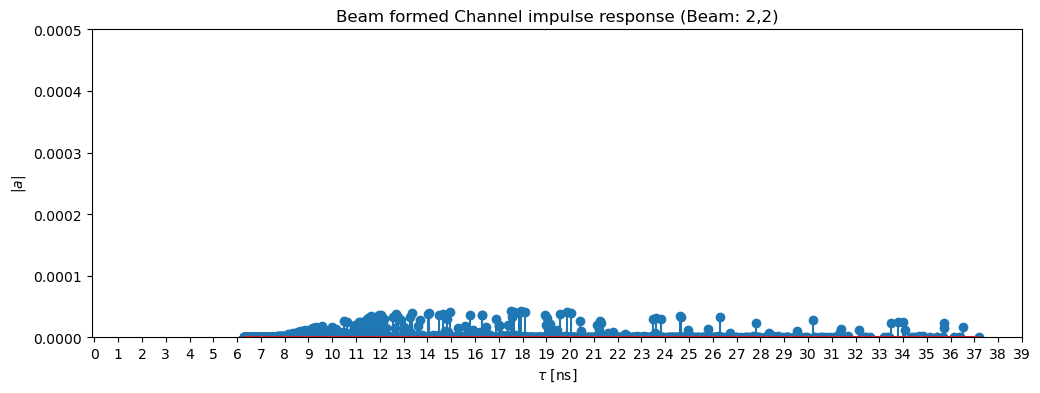

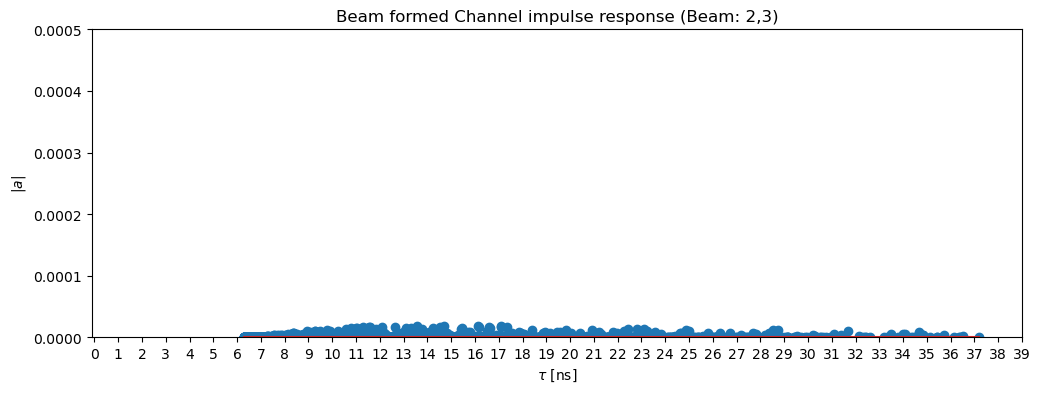

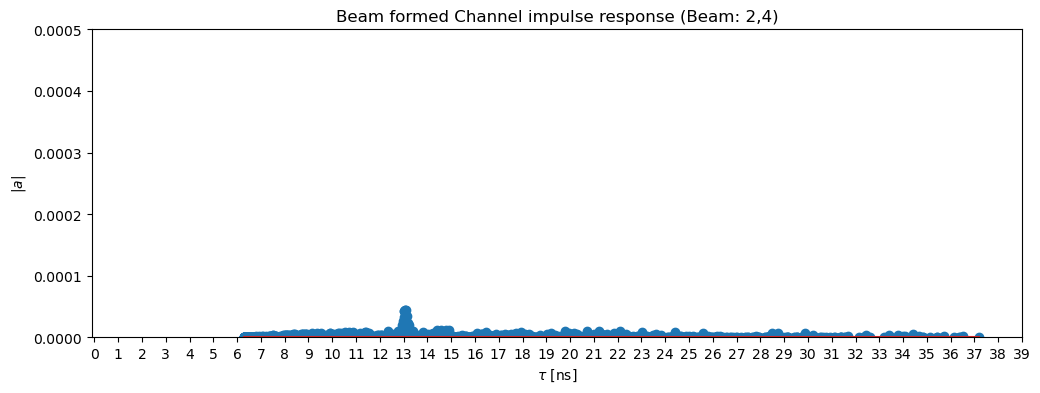

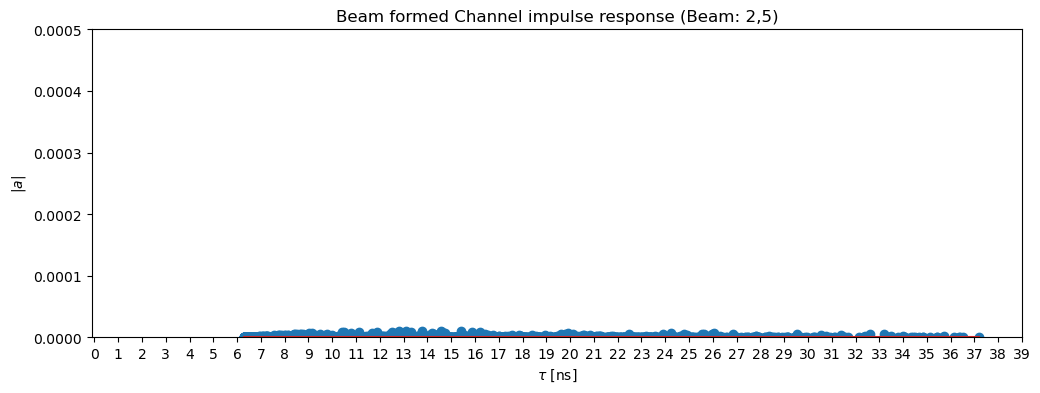

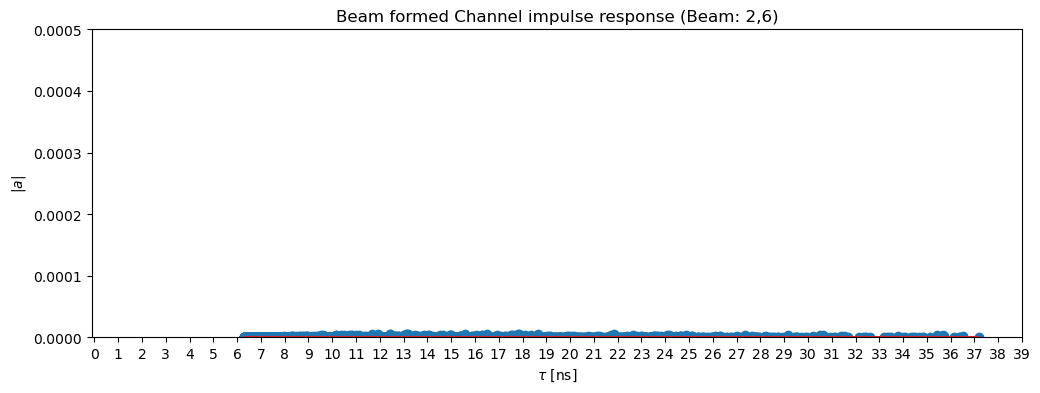

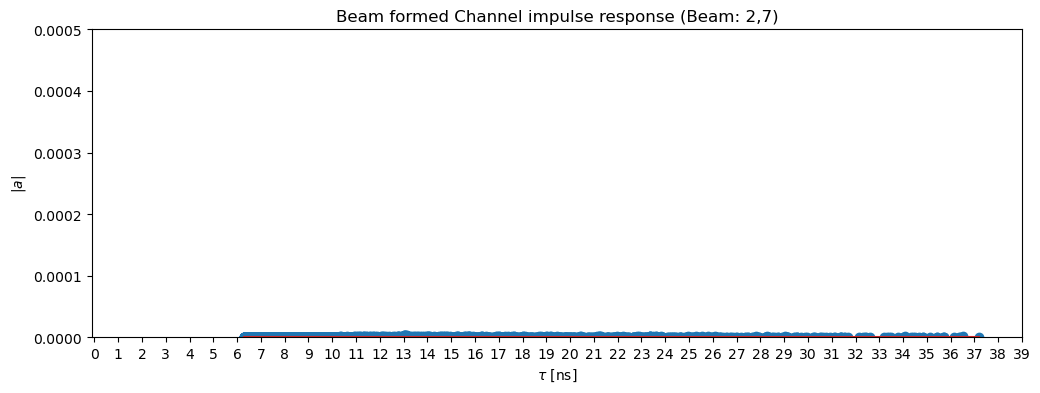

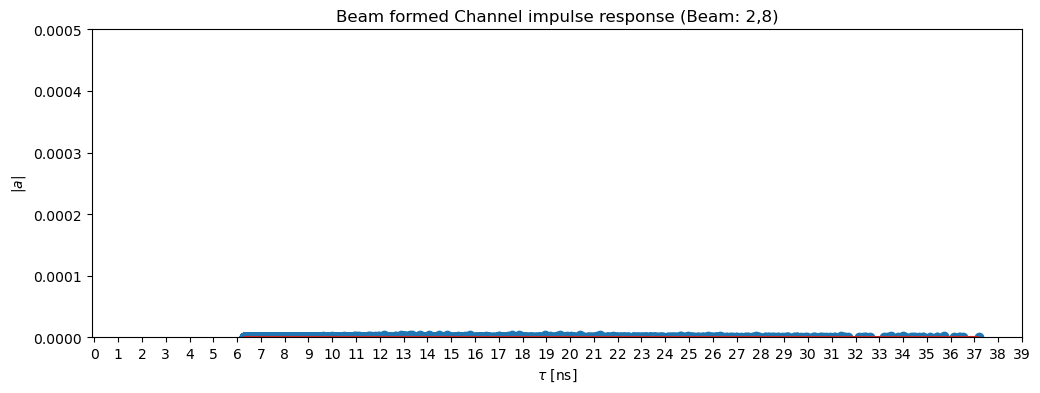

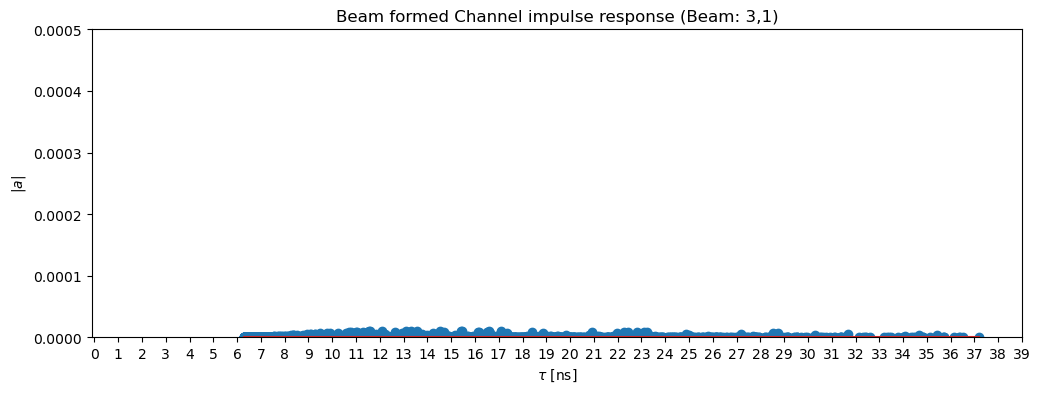

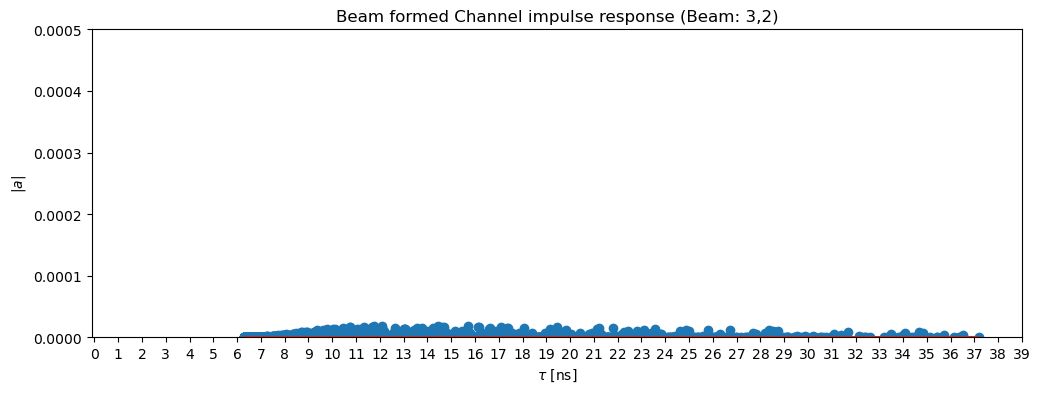

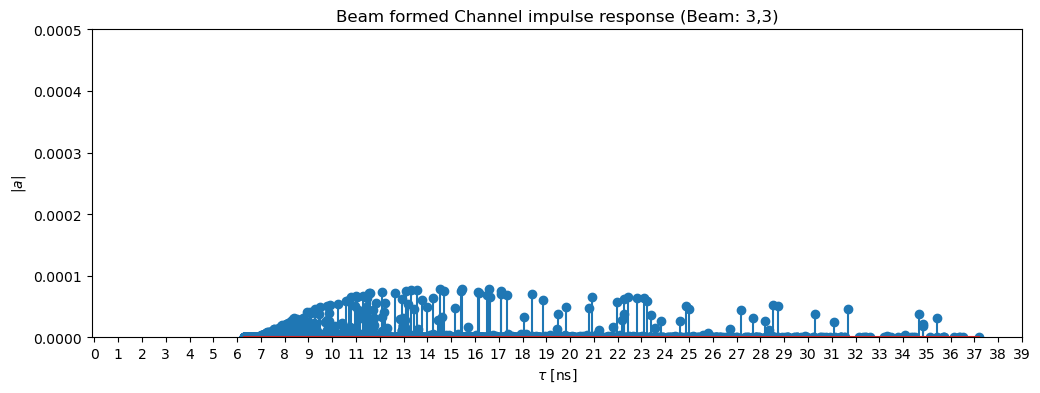

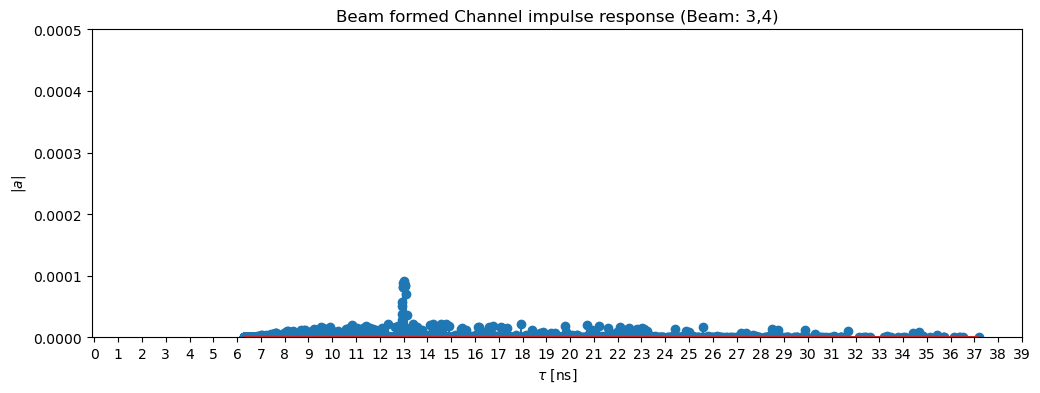

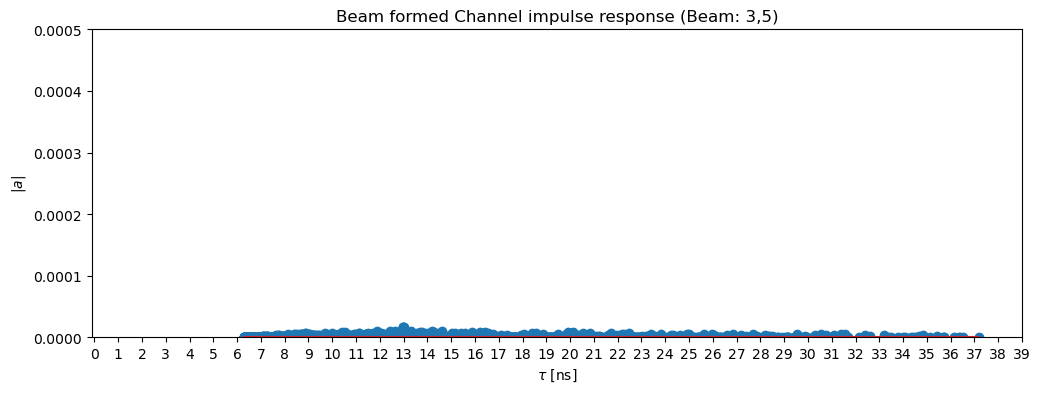

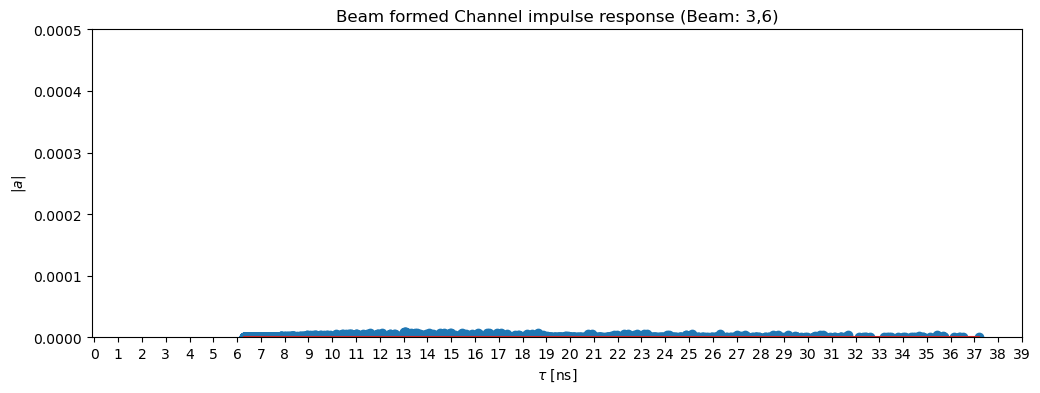

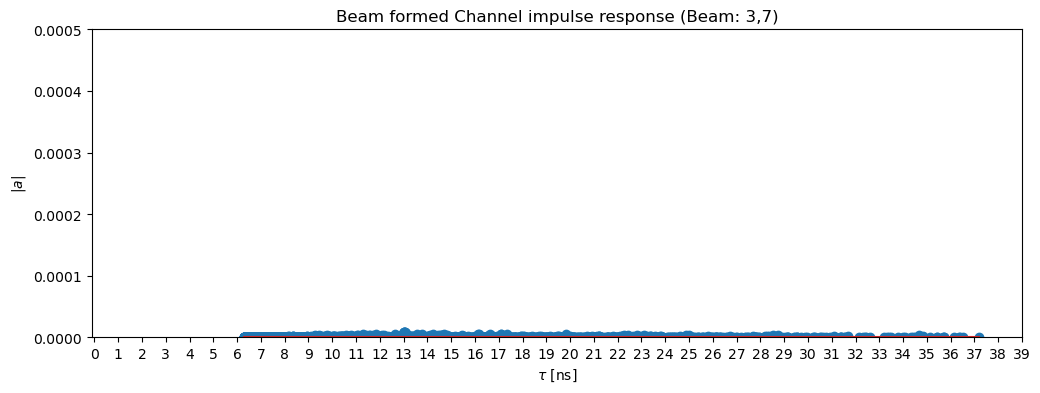

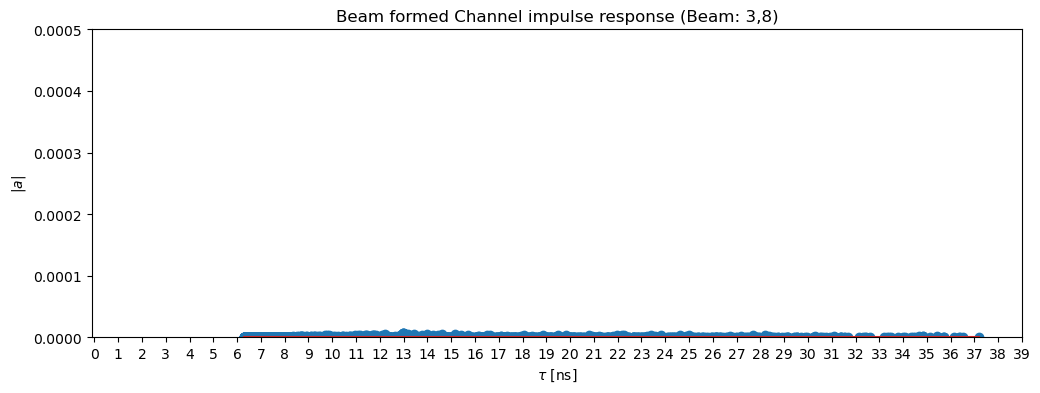

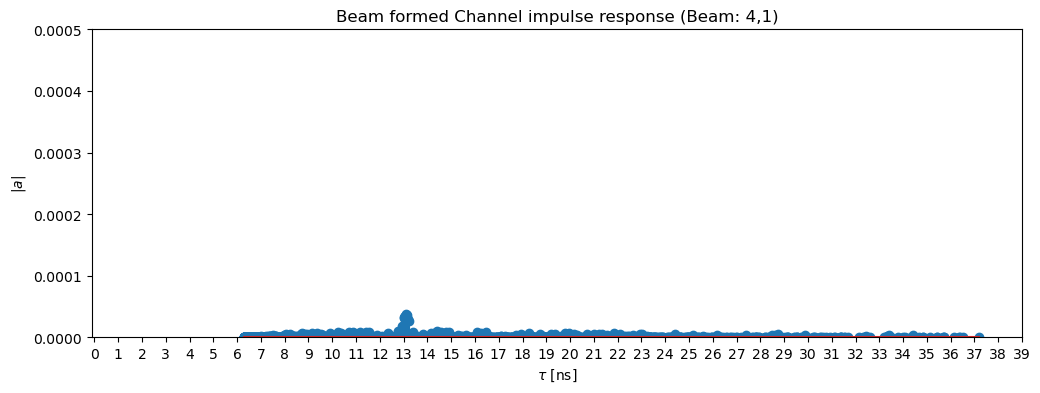

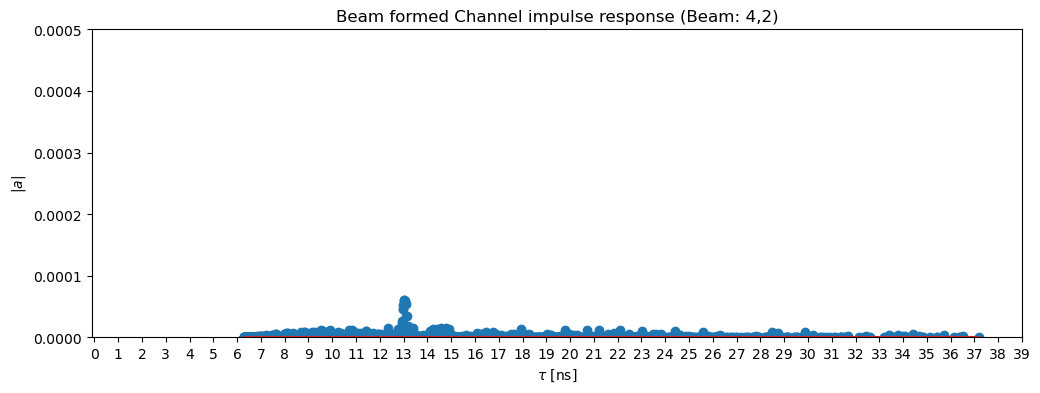

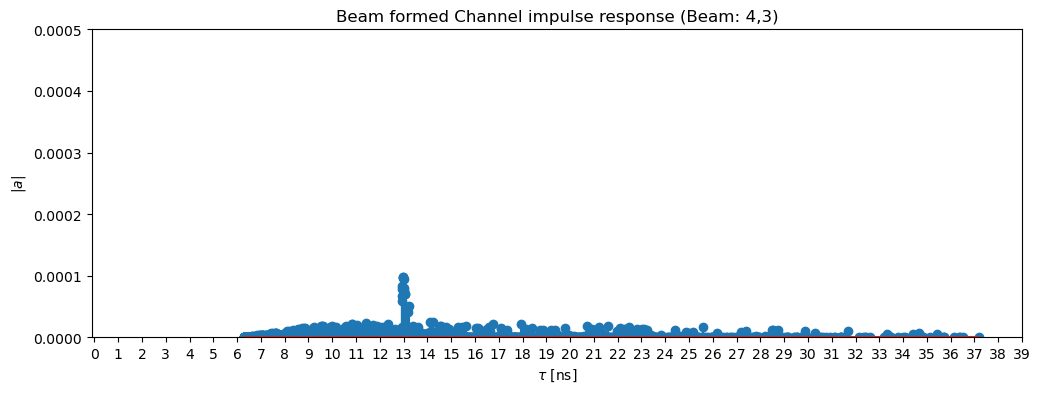

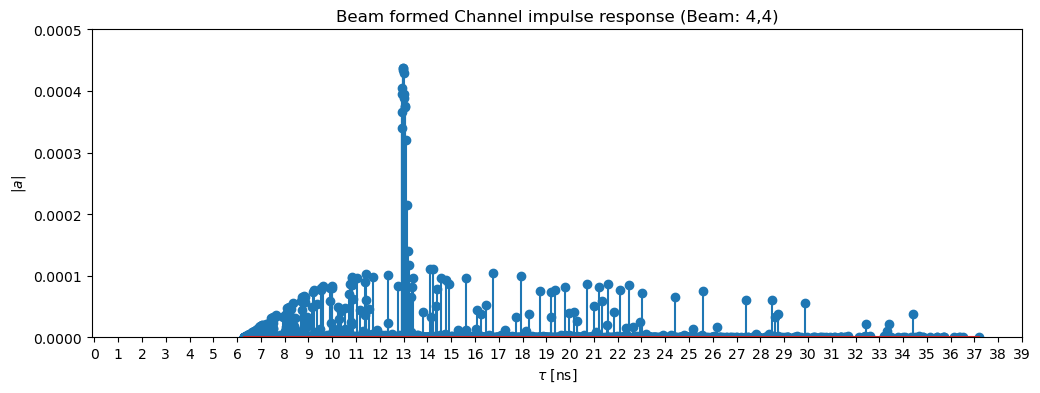

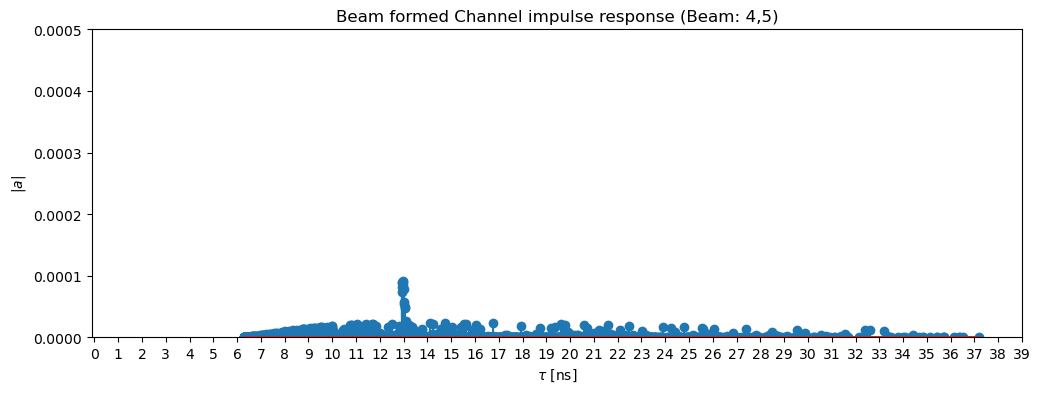

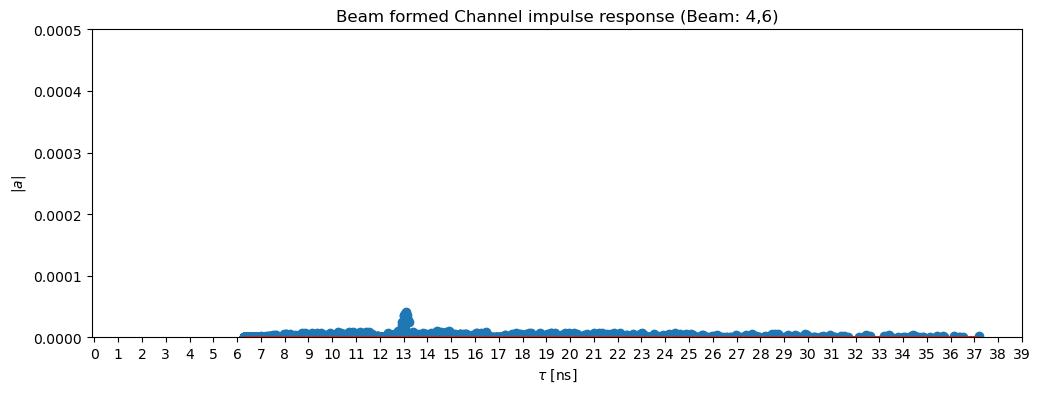

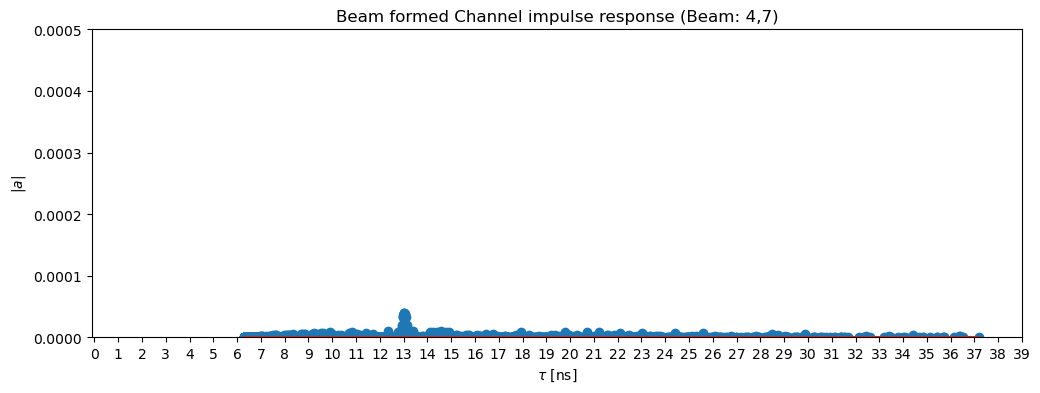

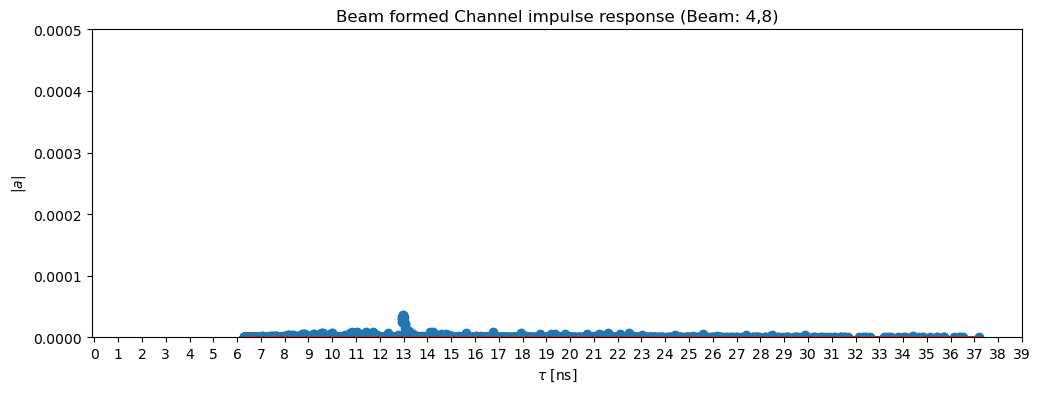

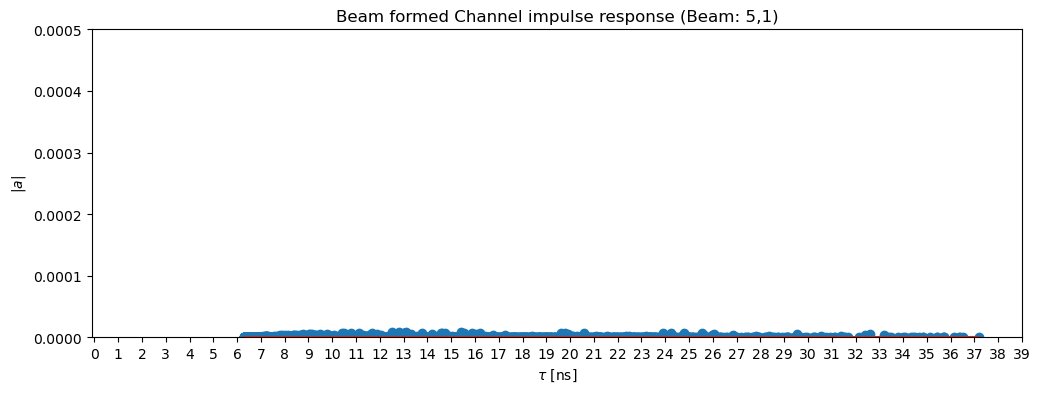

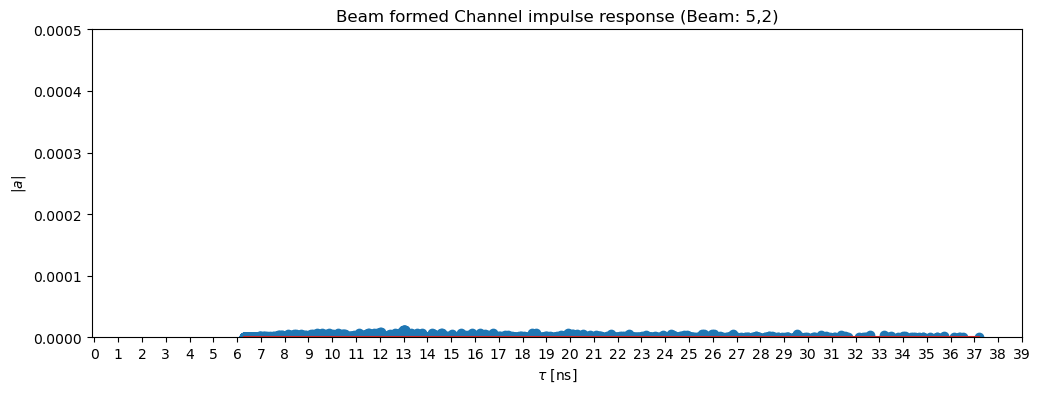

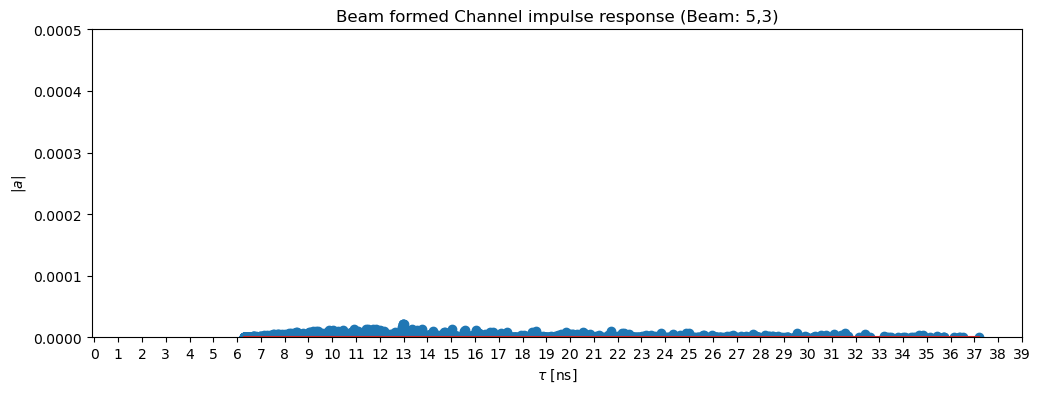

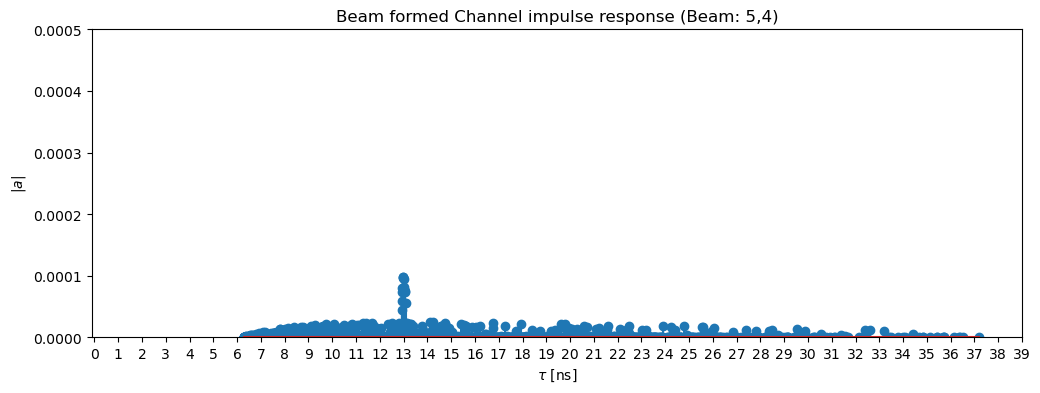

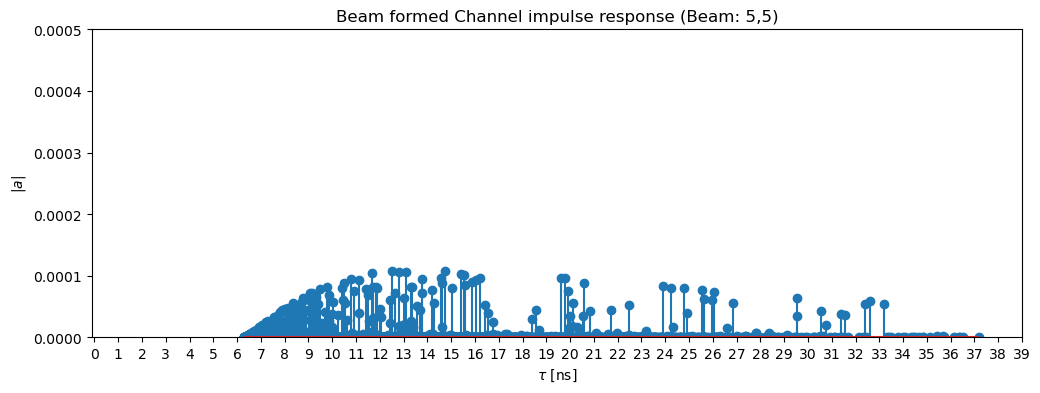

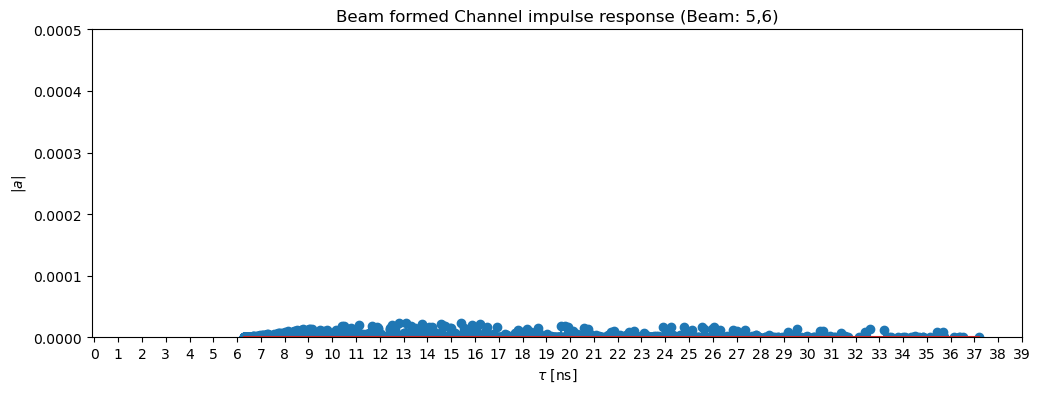

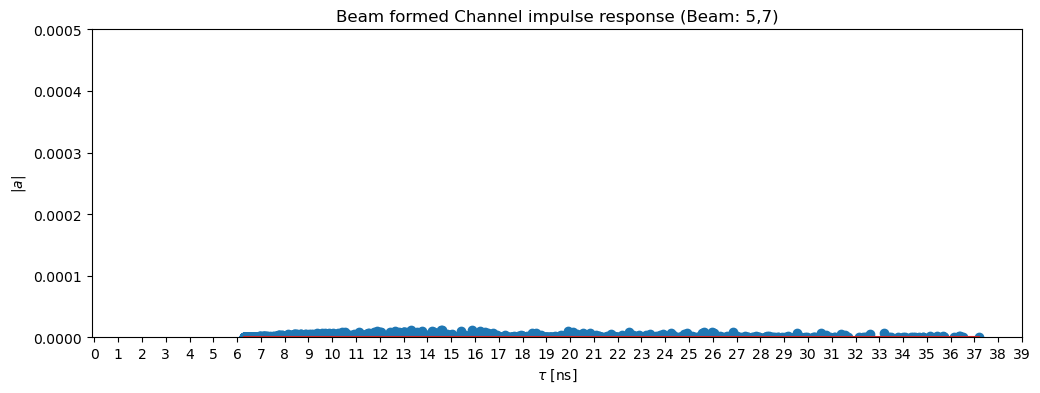

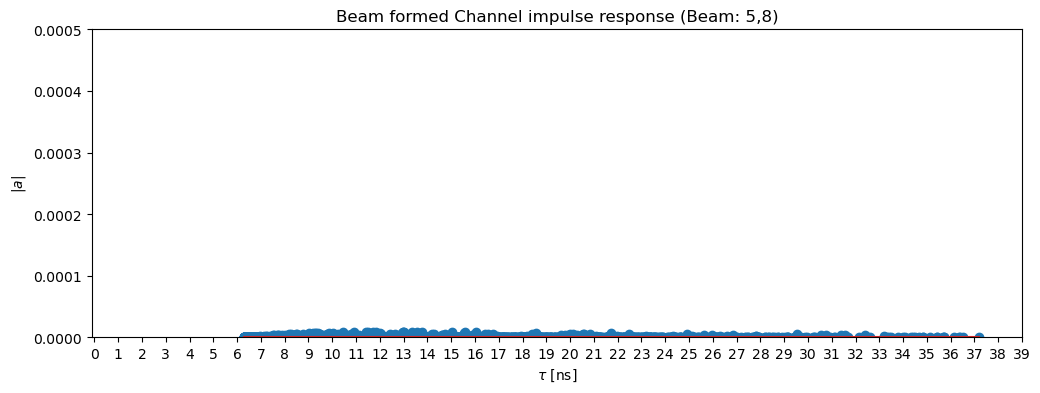

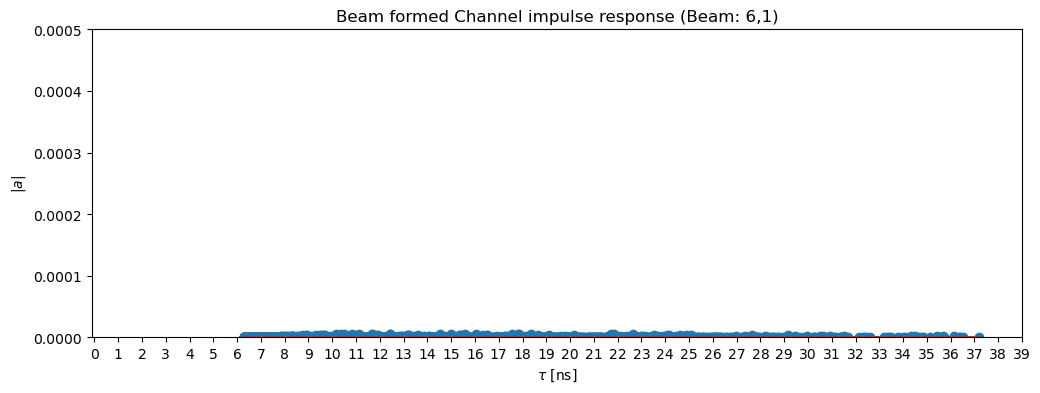

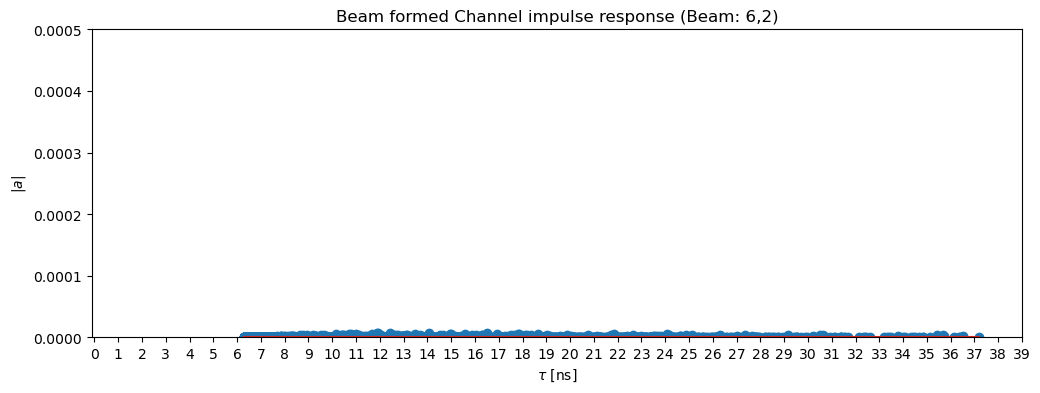

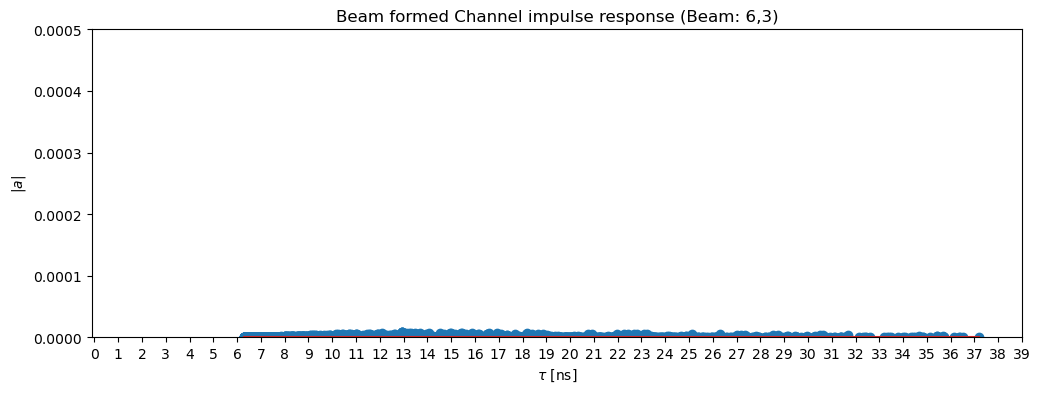

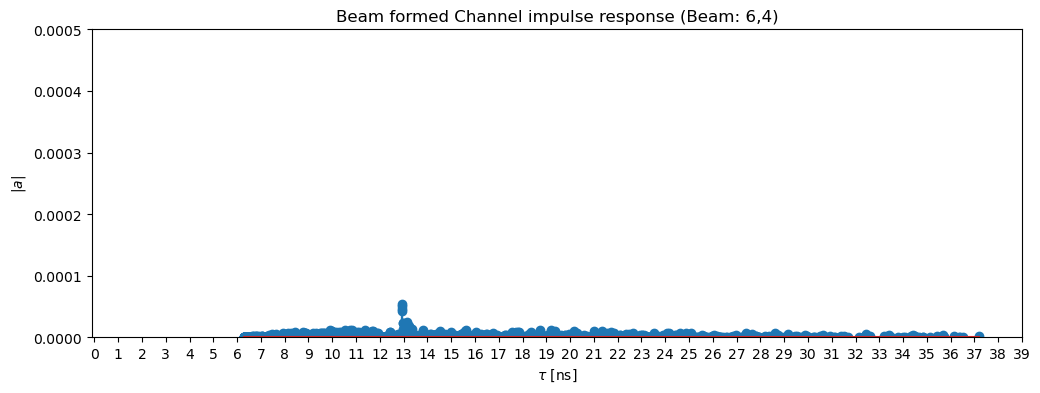

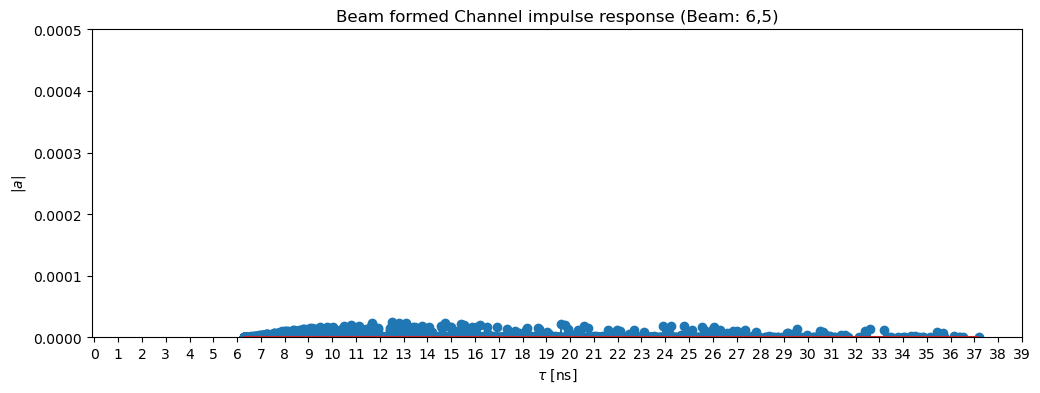

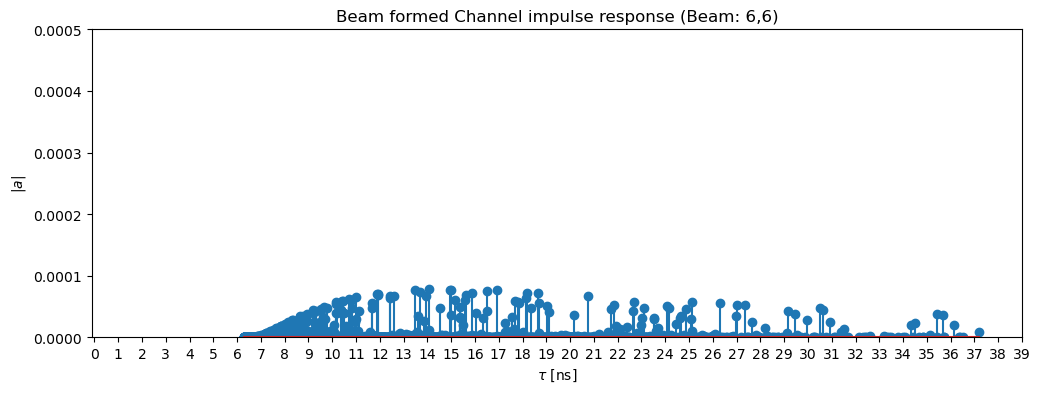

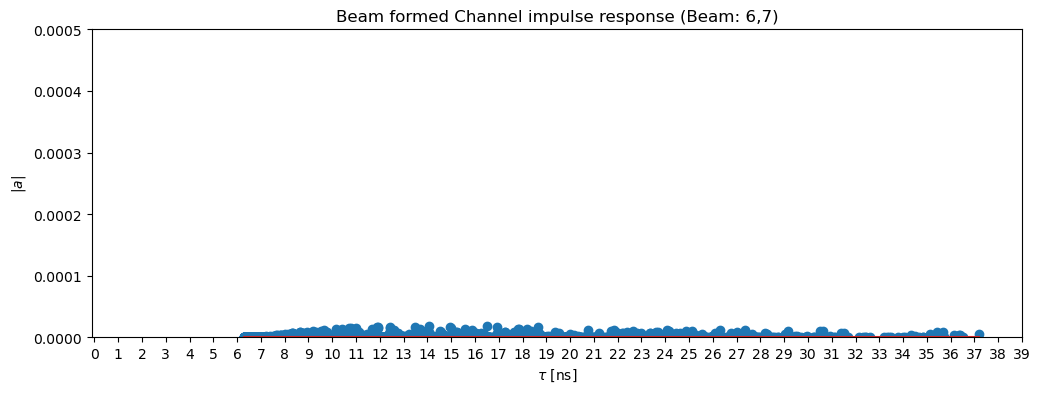

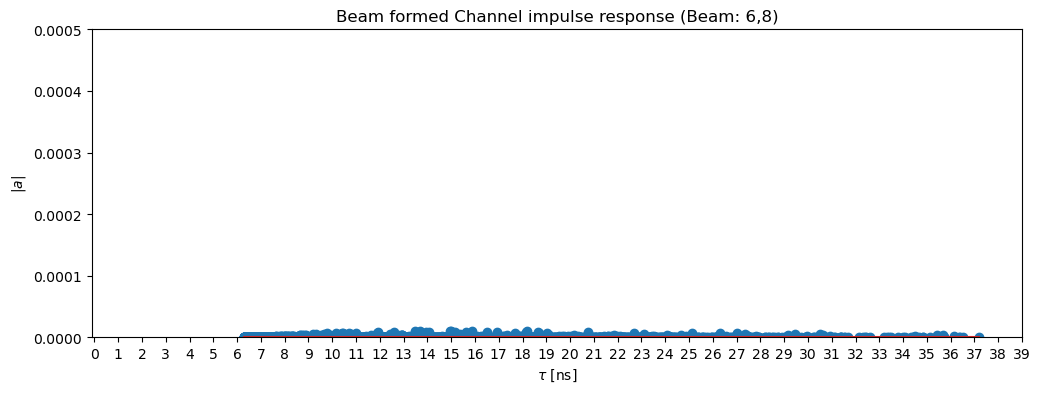

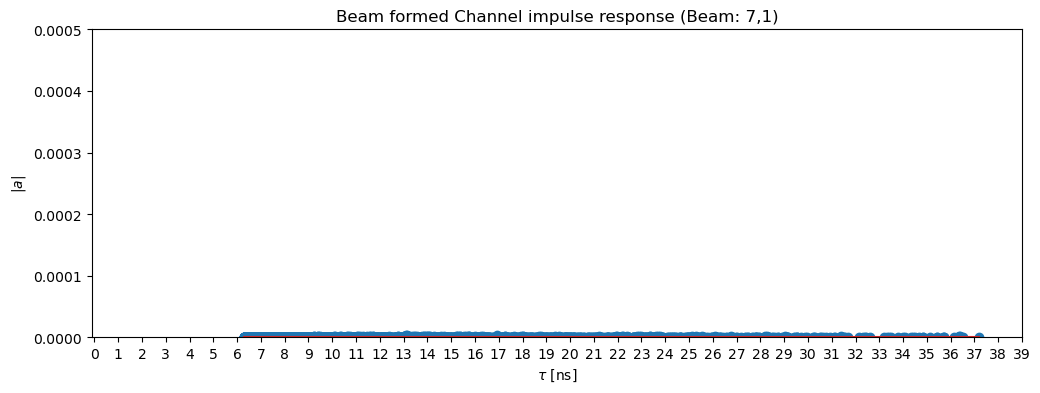

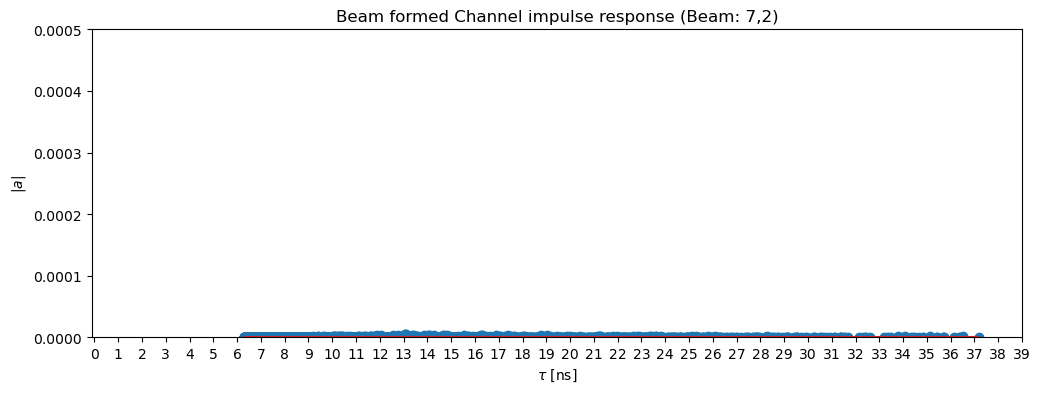

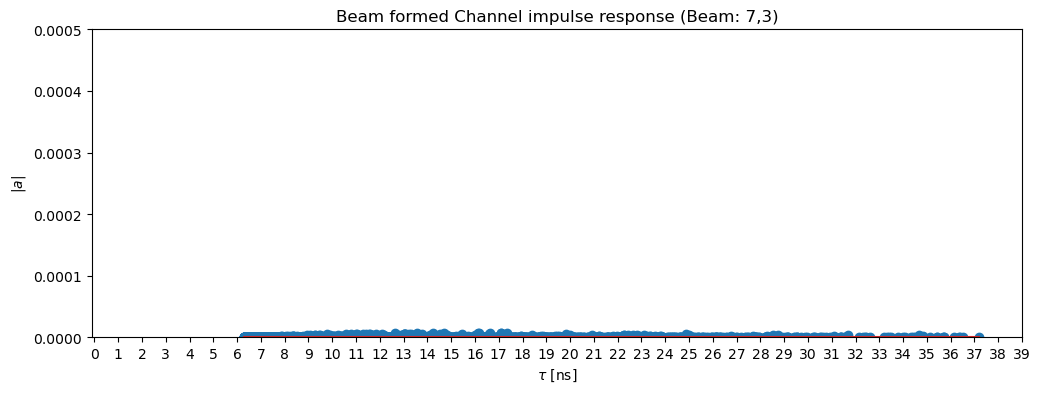

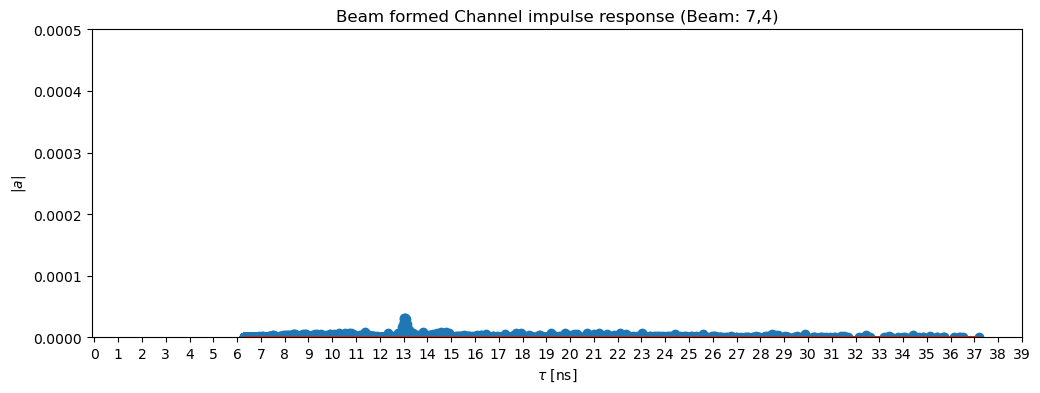

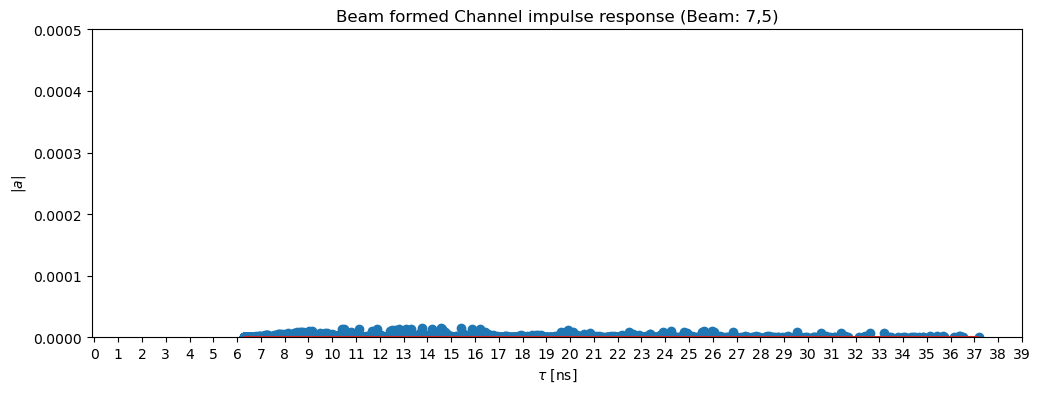

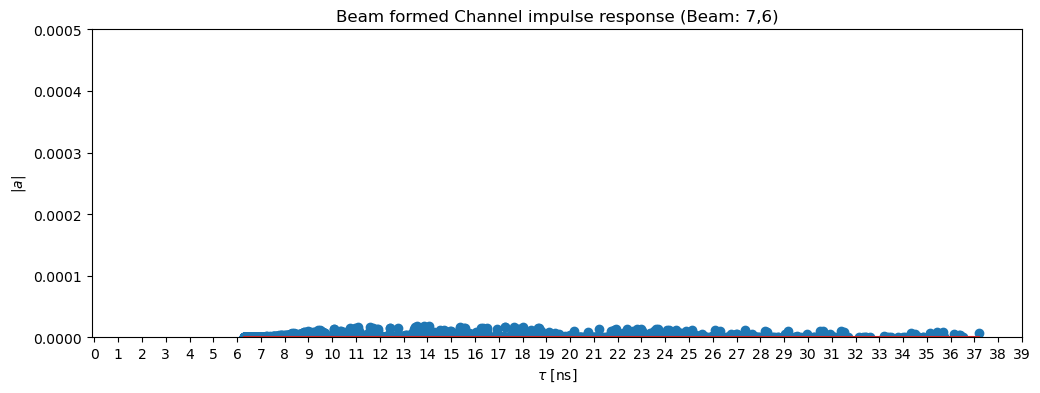

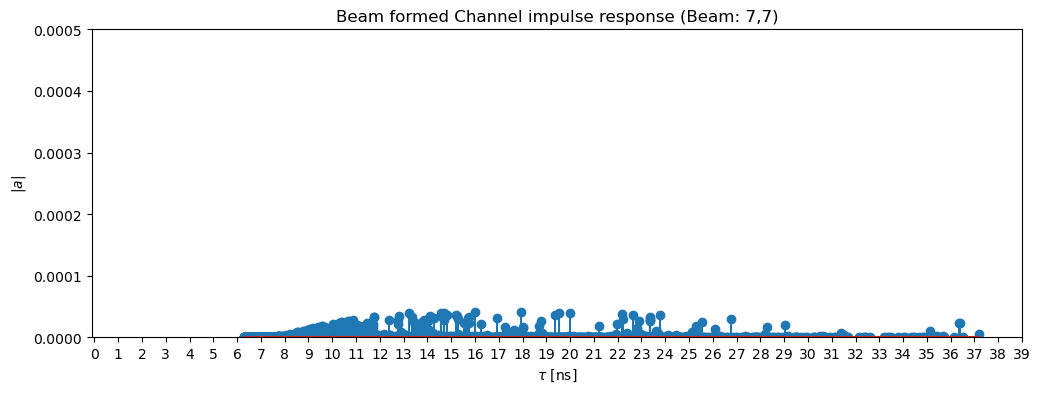

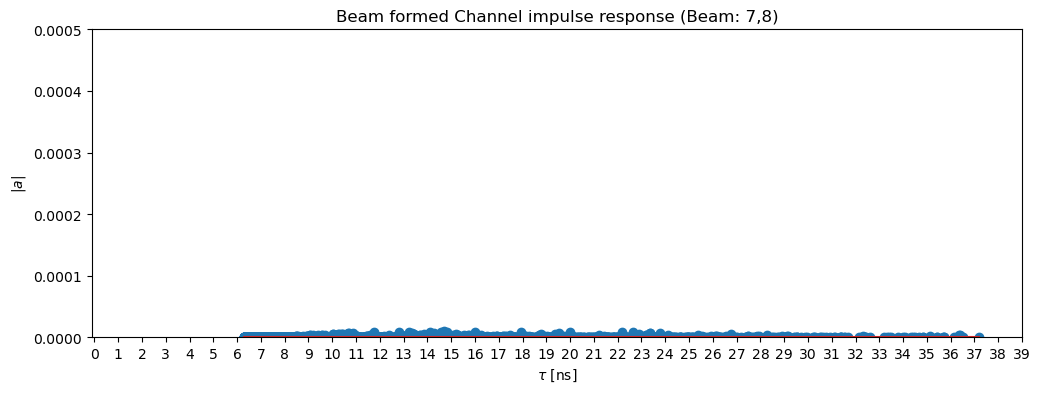

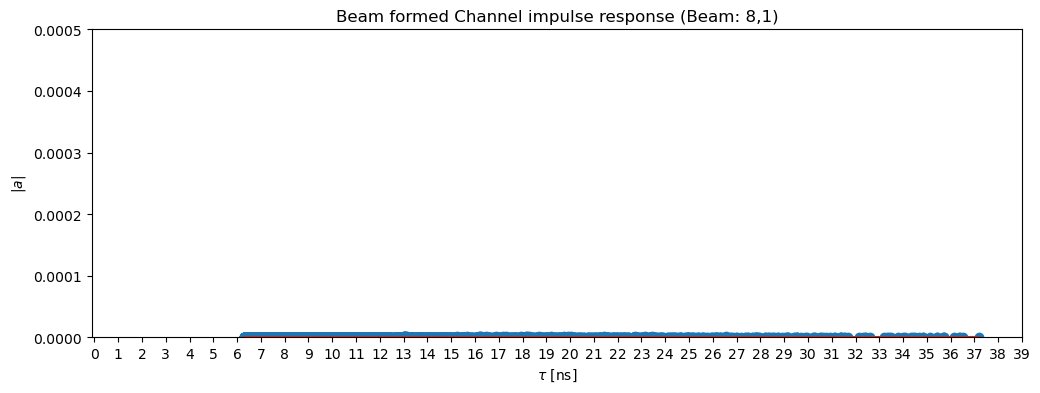

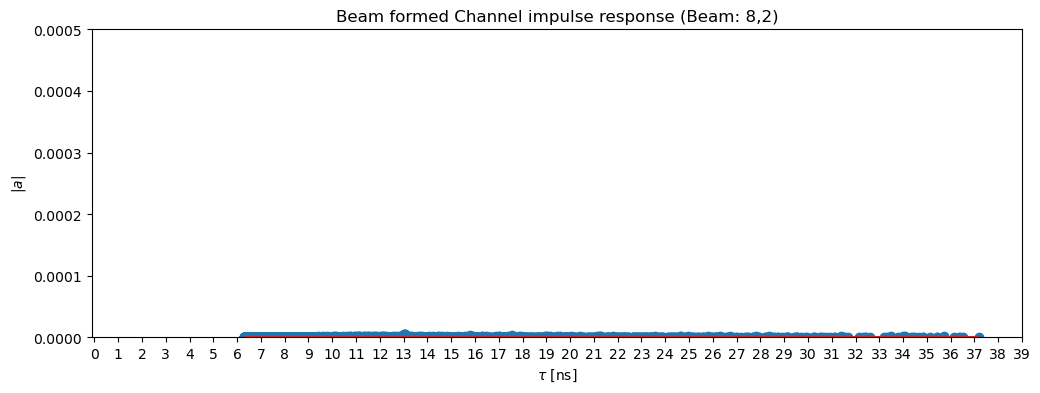

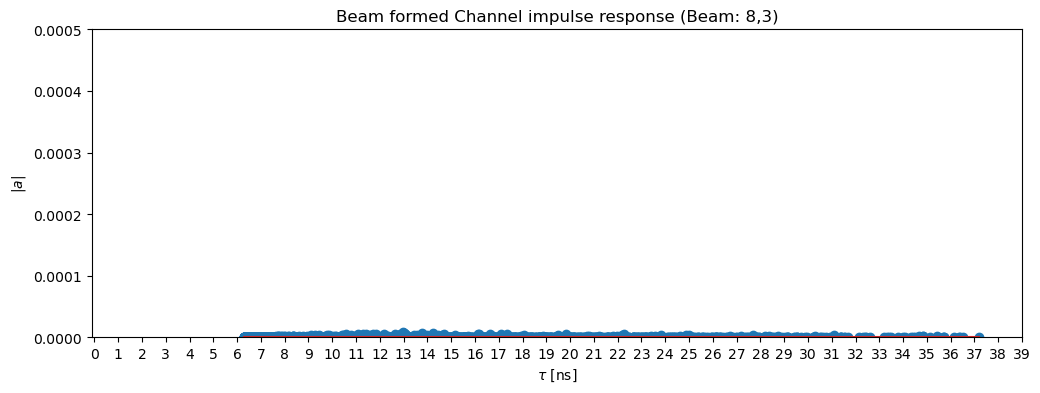

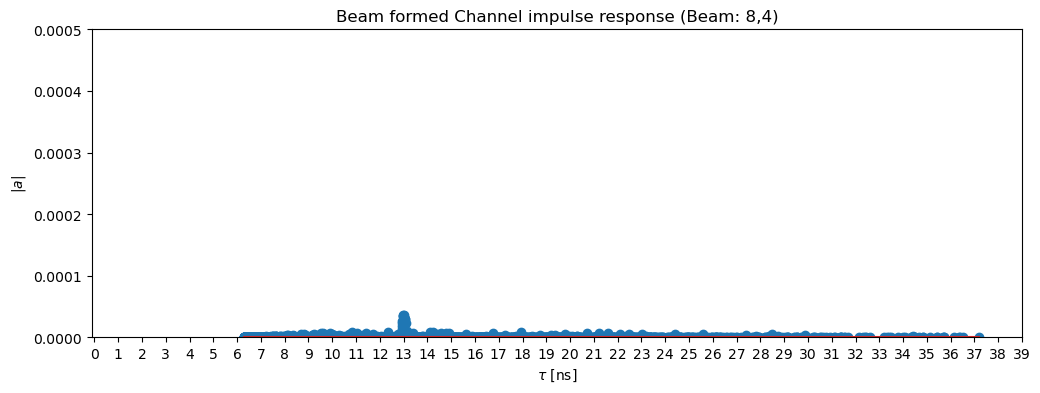

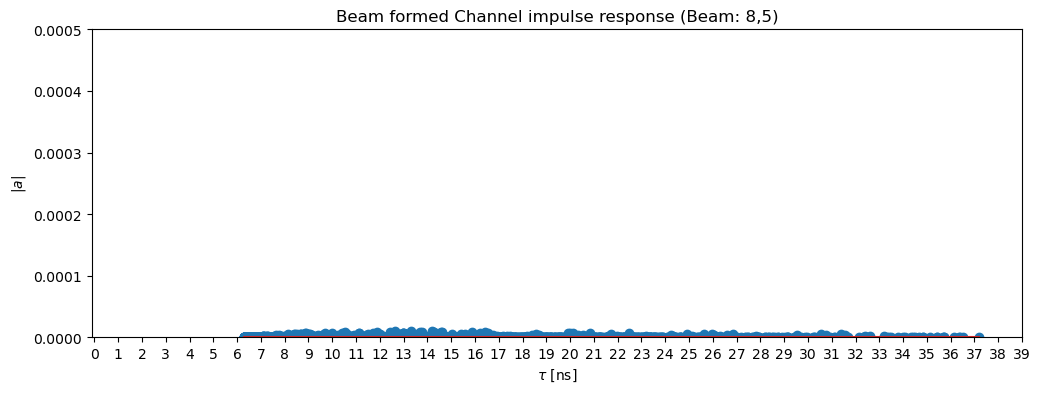

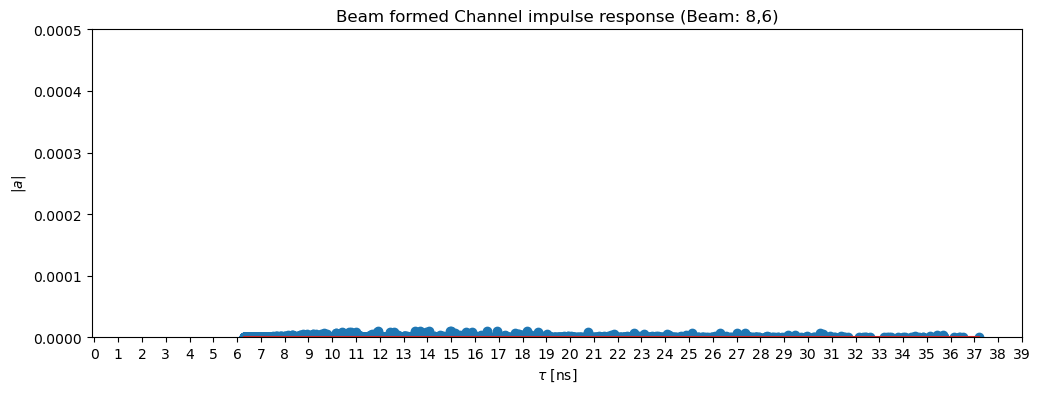

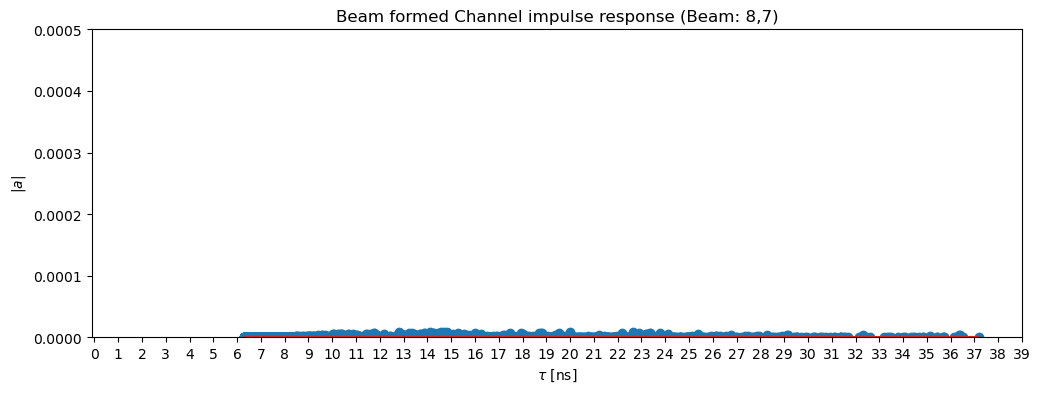

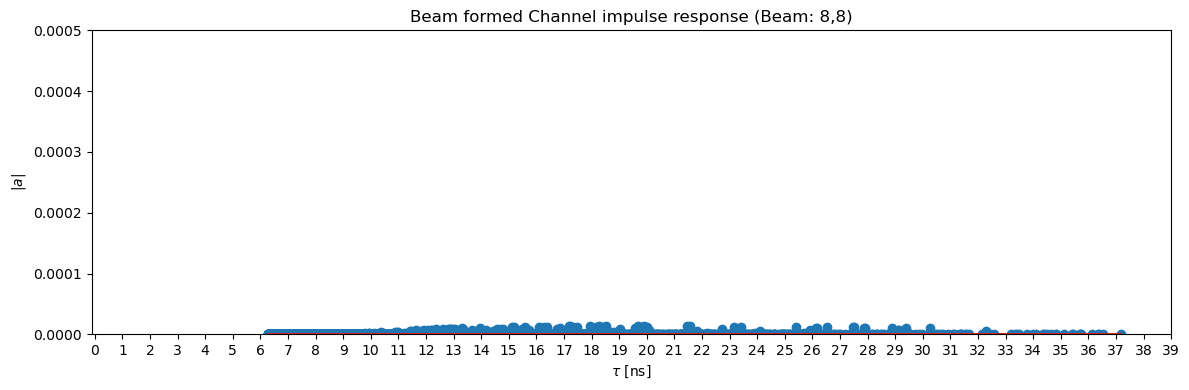

In [24]:
for column in channel_magnitude_df_nlos.columns:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))   
    ax.set_title(f"Beam formed Channel impulse response (Beam: {column})")
    ax.stem(channel_magnitude_df_nlos.index*1e9, channel_magnitude_df_nlos[column])
    ax.set_xlim([-0.1, 39])
    ax.set_ylim([-2e-12, 5e-4])
    ax.set_xlabel(r"$\tau$ [ns]")
    ax.set_ylabel(r"$|a|$")
    ax.set_xticks(np.arange(0, 40, 1))

# subplots do not overlap
plt.tight_layout()
plt.show()

In [25]:
#m = channel_magnitude_df.query('index > 11e-9').max()
m = channel_magnitude_df_nlos.max()
index_of_max = m.idxmax()
m

1,1    0.000014
1,2    0.000010
1,3    0.000010
1,4    0.000037
1,5    0.000009
         ...   
8,4    0.000036
8,5    0.000010
8,6    0.000011
8,7    0.000009
8,8    0.000014
Length: 64, dtype: float64

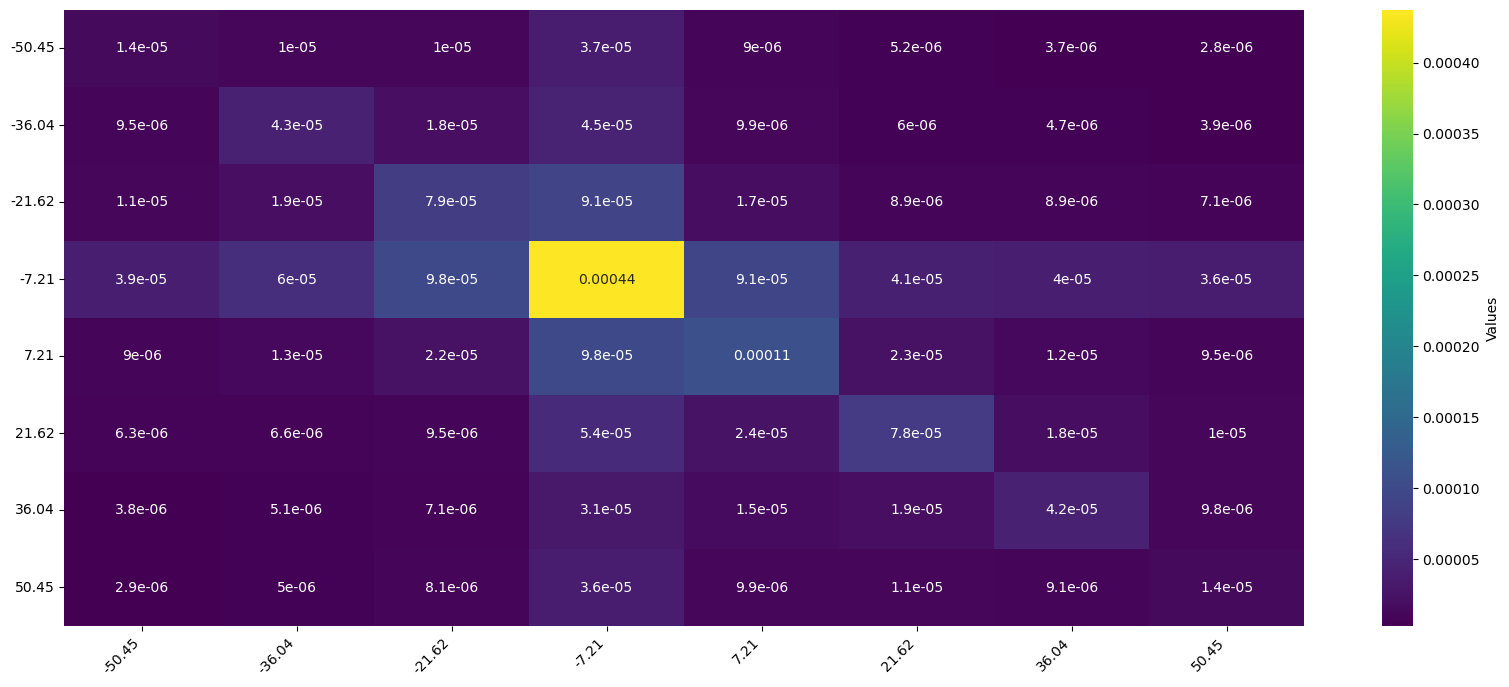

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the data into a 2D array --> L_t*L_r
data_matrix = m.values.reshape(L_t, L_r)

plt.figure(figsize=(20, 8))  
# Create a heatmap using seaborn
sns.heatmap(data_matrix, cmap='viridis', annot=True, cbar_kws={'label': 'Values'})

#plt.xticks(np.arange(L_r) + 0.5, range(1, L_r+1))
#plt.yticks(np.arange(L_t) + 0.5, range(1, L_t+1))
plt.xticks(np.arange(L_r) + 0.5, ["{:.2f}".format(deg) for deg in beam_degs], rotation=45, ha='right')
plt.yticks(np.arange(L_t) + 0.5, ["{:.2f}".format(deg) for deg in beam_degs], rotation=0, ha='right')
# Display the heatmap
plt.show()

In [27]:
#print(azimuth_departure_list)
#print(azimuth_arrival_list)

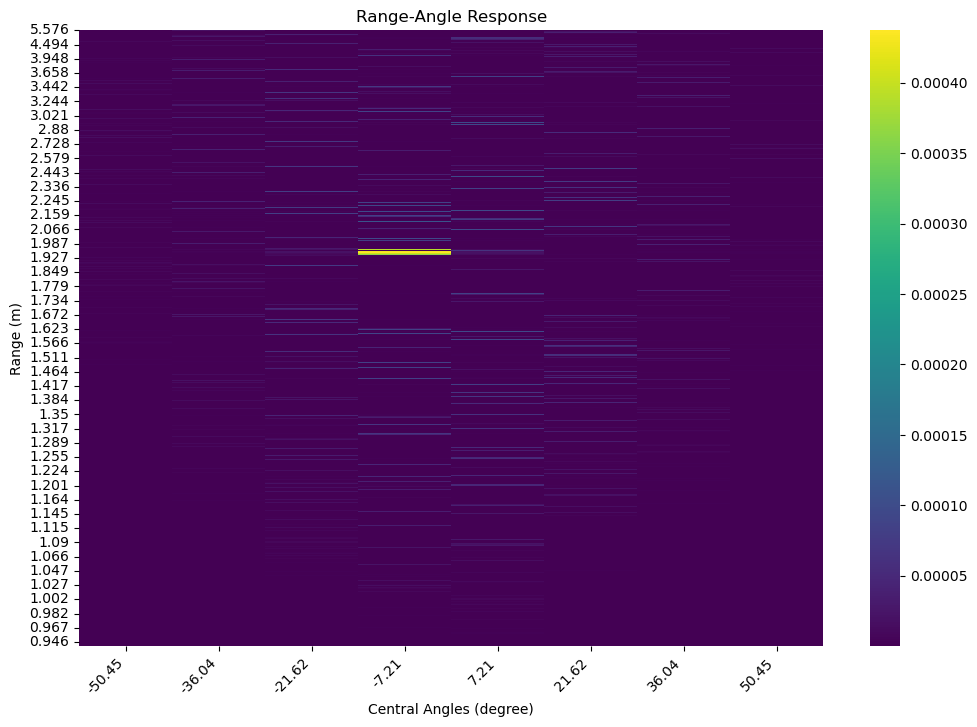

In [28]:
filtered_columns = [col for col in channel_magnitude_df_nlos.columns if col.split(',')[0] == col.split(',')[1]]

# Create a new DataFrame with only the filtered columns
df_filtered = channel_magnitude_df_nlos[filtered_columns]
df_filtered.index = np.round(df_filtered.index * (c / 2), decimals=3) #  fast time (s)  --> range (m) 
df_filtered = df_filtered.sort_index(ascending=False)

plt.figure(figsize=(12, 8))
sns.heatmap(df_filtered, cmap='viridis')  
plt.xlabel('Central Angles (degree)')
plt.ylabel('Range (m)')
plt.title('Range-Angle Response')
plt.yticks( rotation=0, ha='right')
plt.xticks(np.arange(L_r) +0.5 , ["{:.2f}".format(deg) for deg in beam_degs], rotation=45, ha='right')
plt.show()


In [29]:
diff = [departure - arrival for departure, arrival in zip(azimuth_departure_list, azimuth_arrival_list)]
diff

[-180.0,
 -56.440605,
 -112.59365,
 -157.2505,
 -57.39016,
 -70.40222,
 -69.79585,
 -48.394573,
 -20.152359,
 -10.946922,
 -49.64193,
 -37.565434,
 -46.743126,
 -34.012806,
 -33.42266,
 -18.319141,
 -18.275692,
 -2.1964798,
 -34.802467,
 -18.112438,
 -25.380762,
 -9.720623,
 -19.713198,
 -26.07131,
 -5.4679184,
 -11.225342,
 -25.952858,
 -8.004967,
 -23.831493,
 -7.134575,
 -15.970272,
 -18.549503,
 -16.512133,
 -23.163723,
 -22.359243,
 -15.465942,
 -13.781448,
 -15.035757,
 -19.590899,
 -14.670513,
 -20.667658,
 -4.7676315,
 -20.198784,
 -9.22723,
 -4.303543,
 -5.715866,
 -4.1715546,
 -11.373901,
 -9.002125,
 -13.408154,
 -9.934769,
 -12.05463,
 -6.573078,
 -3.6381073,
 -6.8881187,
 -12.398151,
 -4.6707535,
 -15.431166,
 -5.9855347,
 -5.2720947,
 -15.865992,
 -8.994003,
 -16.37595,
 -10.801476,
 -16.17926,
 -1.1565399,
 -13.35405,
 -10.832264,
 -2.4305878,
 -0.46624756,
 -13.437363,
 -9.76284,
 -11.005795,
 -15.643101,
 -12.023085,
 -10.058857,
 -14.965321,
 -9.855495,
 -12.178141,
 

# Self-Interference Channel

In [30]:
h_los , tau_los = paths.cir(los=True, reflection=False, diffraction=False, scattering=False)
h_los

<tf.Tensor: shape=(1, 1, 12, 1, 12, 1, 1), dtype=complex64, numpy=
array([[[[[[[-0.00041884+3.2354448e-09j]],

           [[ 0.00041884-2.9724838e-09j]],

           [[-0.00041884+3.3086769e-09j]],

           [[ 0.00041884-3.2454339e-09j]],

           [[-0.00041884+2.9824732e-09j]],

           [[ 0.00041884-2.7195122e-09j]],

           [[-0.00041884+3.2554233e-09j]],

           [[ 0.00041884-2.9924623e-09j]],

           [[-0.00041884+2.7295013e-09j]],

           [[ 0.00041884-2.4665403e-09j]],

           [[-0.00041884+2.2035795e-09j]],

           [[ 0.00041884-1.1417465e-09j]]]],



         [[[[ 0.00041884-3.4984058e-09j]],

           [[-0.00041884+3.2354448e-09j]],

           [[ 0.00041884-3.4717789e-09j]],

           [[-0.00041884+3.3086769e-09j]],

           [[ 0.00041884-3.2454339e-09j]],

           [[-0.00041884+2.9824732e-09j]],

           [[ 0.00041884-3.1189482e-09j]],

           [[-0.00041884+3.2554233e-09j]],

           [[ 0.00041884-2.9924623e-09j]],

     

In [31]:
h_los_reshaped = tf.squeeze(h_los)
h_los_reshaped = np.expand_dims(h_los_reshaped, axis=0)

In [32]:
tau_los = tf.squeeze(tau_los)
tau_los

<tf.Tensor: shape=(), dtype=float32, numpy=2.1428574e-10>

In [33]:
beam_formed_si_signal = tf.matmul(h_los_reshaped, transmitting_codebook_matrix) # (batch size, N_r, L_t)
beam_formed_si_signal = tf.matmul(receiving_codebook_matrix, beam_formed_si_signal, adjoint_a=True) # (batch size, L_r, L_t)

# Reshape the tensor to a 2D array
reshaped_array = tf.reshape(beam_formed_si_signal, (1, L_r * L_t))
columns = [f'{i},{j}' for i in range(1, L_r + 1) for j in range(1, L_t + 1)]
df_los = pd.DataFrame(reshaped_array.numpy(), columns=columns)
df_los = df_los.set_index(pd.Index([tau_los.numpy()]))

channel_magnitude_df_los = abs_complex_columns(df_los)
filtered_columns = [col for col in channel_magnitude_df_los.columns if col.split(',')[0] == col.split(',')[1]]

DFT_beamforming_attenuation = channel_magnitude_df_los[filtered_columns]
DFT_beamforming_attenuation

,"1,1","2,2","3,3","4,4","5,5","6,6","7,7","8,8"
2.142857e-10,0.000169,0.000094,0.000025,0.000018,0.000018,0.000025,0.000094,0.000169
